In [87]:
library(dplyr)
library(ggplot2)
library(data.table)

setwd("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM")

source("/mnt/lareaulab/reliscu/code/ggplot_theme.R")

theme_set(default_theme())
options(repr.matrix.max.cols=Inf) 

In [88]:
cell_meta <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/data/scRNA-seq/tasic_2018/ALM/tasic_2018_ALM_STAR_sampleinfo.csv", data.table=FALSE)

In [89]:
cell_meta$cell_subclass <- gsub(" ", "_", cell_meta$cell_subclass)
cell_meta$cell_subclass <- gsub("-", "_", cell_meta$cell_subclass)
cell_meta$cell_subclass <- gsub("/", "_", cell_meta$cell_subclass, fixed=TRUE)

In [90]:
sort(table(cell_meta$cell_subclass))


        L4       Peri         CR      Meis2        SMC       VLMC   Serpinf1 
         3          4         11         11         55         72         78 
Macrophage       Endo      Oligo        L6b       Sncg      Astro    L2_3_IT 
        85         96         98        145        148        215        325 
     L6_CT      L5_PT      L6_IT         NP      Pvalb      Lamp5        Sst 
       350        368        394        542        896        913       1139 
       Vip      L5_IT 
      1224       2401 

In [ ]:
get_top_corr_mods <- function(network_dir, pseudobulk_legend, top_qval_mods_df) {
    ctypes <- top_qval_mods_df$Cell_type
    top_corr_mods_list <- vector(mode="list", length=length(ctypes))

    for (i in seq_along(ctypes)) {
        # Get # cells in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        if (var(frac_per_sample) > 0) {
            # Get most enriched cell type module
            old_mod <- top_qval_mods_df$Module[i]
            ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
            ME_vec <- ME_df[,grep(paste0("^", old_mod, "$"), colnames(ME_df))]
            old_corr <- cor(frac_per_sample, ME_vec)

            # Traverse networks to find module most correlated to cell type abundance
            networks <- list.dirs(file.path(getwd(), network_dir), full.names=TRUE, recursive=FALSE)
            networks <- networks[lengths(lapply(networks, list.files)) > 0]

            ME_corrs_list <- lapply(seq_along(networks), function(j) {
                ME_path <- list.files(networks[j])[grep("eigengene", list.files(networks[j]))]
                ME_df <- fread(file.path(networks[j], ME_path), data.table=FALSE)

                ME_corrs <- apply(ME_df[,-1, drop=FALSE], 2, function(ME) {
                    cor(ME, frac_per_sample)
                })

                new_mod <- names(which.max(ME_corrs))
                new_corr <- ME_corrs[which.max(ME_corrs)]
                
                # Save the network the module came from
                network_id <- sapply(strsplit(networks[j], "/"), function(x) x[length(x)])
                
                data.frame(
                    Cell_type=ctypes[i],
                    Cor=new_corr,
                    Old_cor=old_corr,
                    Module=new_mod,
                    Old_module=old_mod,
                    Network=network_id,
                    Old_network=top_qval_mods_df$Network[i],
                    Pseudobulk_SD=round(sd(n_cells_per_sample), 2),
                    New_ME_path=file.path(networks[j], ME_path)
                )
            })
            ME_corrs <- do.call(rbind, ME_corrs_list)
            
            top_corr_mods_list[[i]] <- ME_corrs %>%
                arrange(Network, Module) %>%
                slice_max(Cor, with_ties=F)
        }
    }

    top_corr_mods_df <- do.call(rbind, top_corr_mods_list)
    top_corr_mods_df %>%
        arrange(Cor)
}

get_top_corr_mod_stats <- function(top_corr_mods_df) {
    ctypes <- top_corr_mods_df$Cell_type

    top_corr_mods_df$Mod_stats_path <- sapply(top_corr_mods_df$New_ME_path, function(x) gsub("eigengenes", "statistics", x))

    mod_stats <- fread(top_corr_mods_df$Mod_stats_path[1], data.table=FALSE)
    col_idx <- which(colnames(mod_stats) %in% c("PC1VE", "MeanExpr", "Specificity", "Homogeneity"))
    col_idx <- sort(c(col_idx, grep("^Unique", colnames(mod_stats))))

    stats <- c()
    for (i in seq_along(ctypes)) {
        mod <- top_corr_mods_df$Module[i]
        mod_stats <- fread(top_corr_mods_df$Mod_stats_path[i], data.table=FALSE)
        colnames(mod_stats)[grep("^Unique", colnames(mod_stats))] <- "Unique_members" 
        stats <- rbind(stats, mod_stats[mod_stats$Module == mod, col_idx])
    }

    top_corr_mods_df <- cbind(top_corr_mods_df, stats)
    top_corr_mods_df
}

plot_ctype_abundance_vs_ME <- function(pseudobulk_legend, top_qval_mods_df) {
    options(repr.plot.width=6, repr.plot.height=6)

    ctypes <- top_qval_mods_df$Cell_type

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        # Get eigengene from most enriched cell type module
        mod <- top_qval_mods_df$Module[i]
        ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
        ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

        df <- data.frame(Frac=frac_per_sample, ME=ME_vec)

        subtitle <- paste(
            top_qval_mods_df$Module[i], top_qval_mods_df$Network_short[i], "\n",
            "Cor:", round(cor(frac_per_sample, ME_vec), 2), "\n",
            "Qval =", formatC(top_qval_mods_df$Qval[i], format="e", digits=1) 
        )

        # Plot cell type proportion vs. module eigengene
        
        print(
            ggplot(df, aes(x=Frac*100, y=ME)) +
                geom_point() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("% cells per sample") +
                ylab("Module eigengene")
        )
    }
    
}

plot_ctype_abundance <- function(pseudobulk_legend, top_qval_mods_df) {
    options(repr.plot.width=15, repr.plot.height=6)

    ctypes <- unique(pseudobulk_legend$Cell.type)

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        # frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        n_cells_SD <- round(sd(n_cells_per_sample), 2)
        subtitle <- paste("SD =", n_cells_SD)

        # Plot cell type proportion vs. module eigengene
        df <- data.frame(Sample=1:length(n_cells_per_sample), No.cells=n_cells_per_sample)

        options(repr.plot.width=15, repr.plot.height=6)

        print(
            ggplot(df, aes(x=Sample, y=No.cells)) +
                geom_point() +
                geom_line() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("Sample") +
                ylab("# cells per sample")
        )
    }
    
}

plot_corr_vs_stats <- function(cell_meta, top_corr_mods_df) {
    # Get original # cells per cell type
    top_corr_mods_df <- merge(
        top_corr_mods_df,
        data.frame(sort(table(cell_meta$cell_subclass))), 
        by.x="Cell_type", by.y="Var1"
    )
    corr_col <- grep("^Cor", colnames(top_corr_mods_df))
    top_corr_mods_df <- top_corr_mods_df[!is.na(top_corr_mods_df[,corr_col]),] 
    pal <- colorRampPalette(c("navy", "cyan", "yellow", "red"))(200)
    color_vec <- pal[as.numeric(cut(top_corr_mods_df[,corr_col], breaks=200))]
    plot(top_corr_mods_df$Freq, top_corr_mods_df$Pseudobulk_SD, col=color_vec, pch=16)
    plot(top_corr_mods_df$Freq, top_corr_mods_df[,corr_col])
}

Verify enriched modules actually represent a given cell type by plotting cell type abundance vs. the module eigengene

# Round 3 (0.4% var network; PosFDR module definiton)

In [92]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [93]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [94]:
# # For each (poorly correlated) cell type, see if there exists any module(s) to which they are correlated:

# top_corr_mods_0.4pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_0.4pcnt_PosFDR_df

In [95]:
# plot_ctype_abundance(pseudobulk_legend)

# Round 3 (0.4% var network; PosBC module definiton)

In [96]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

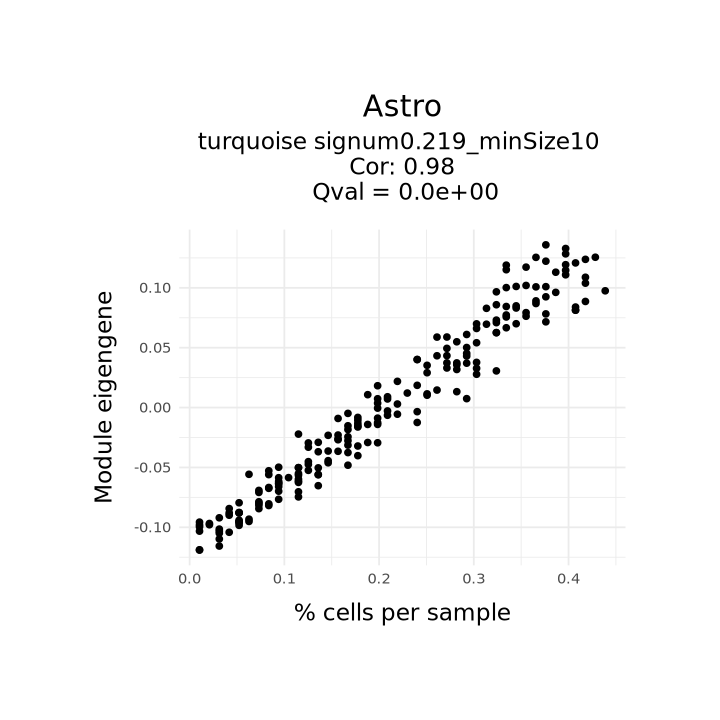

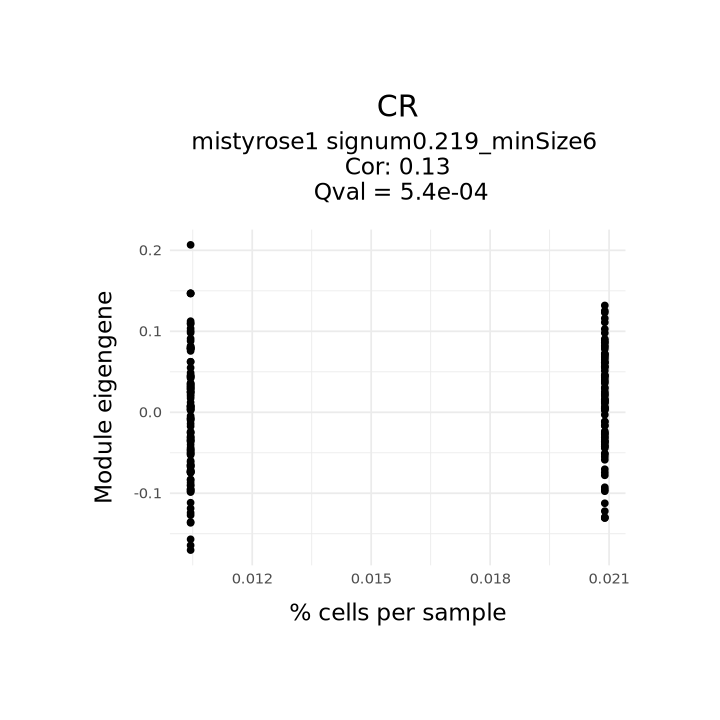

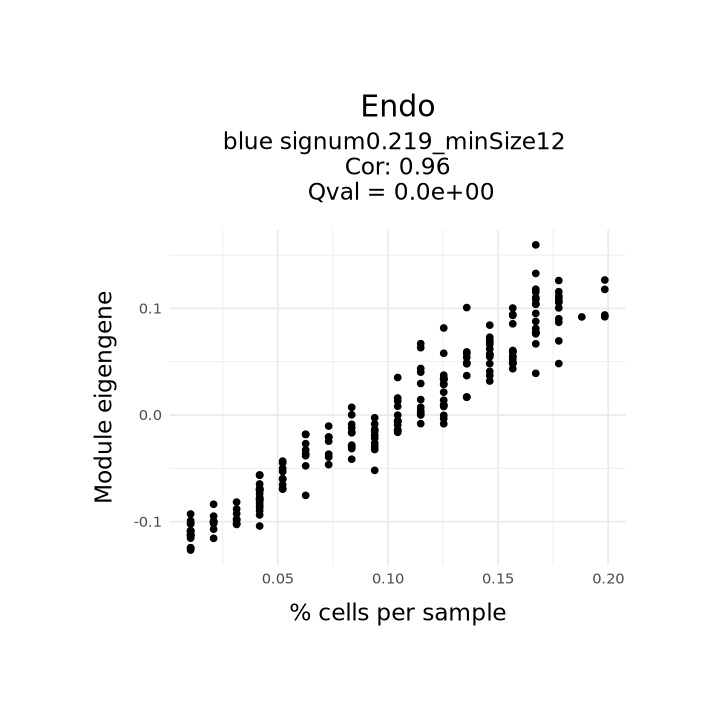

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


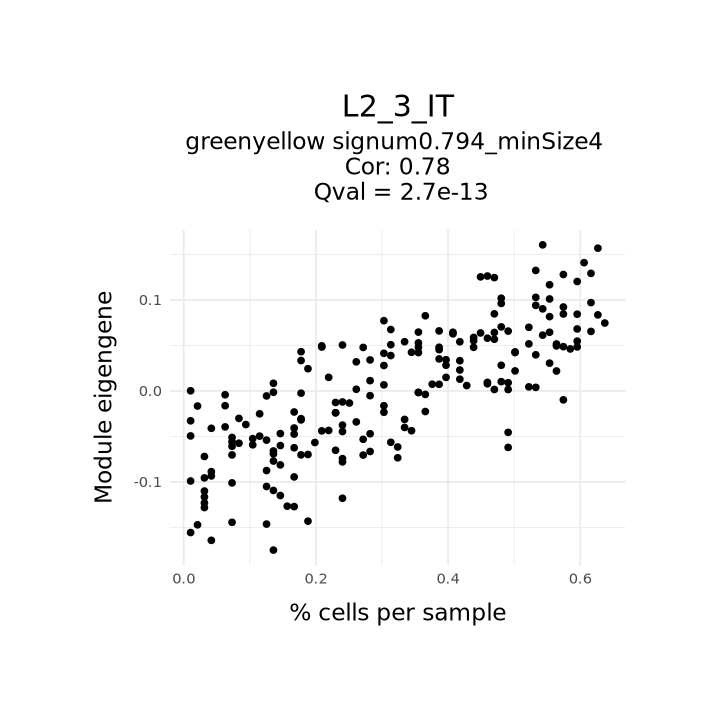

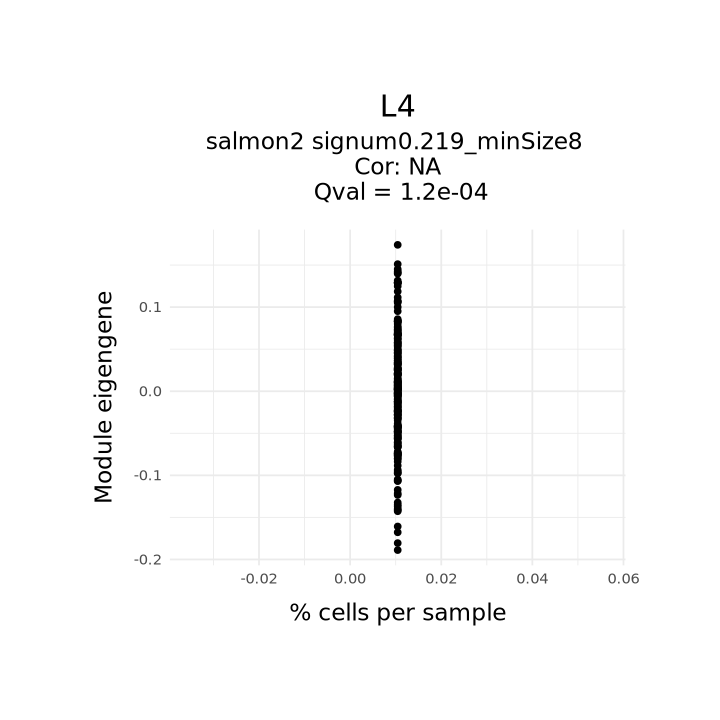

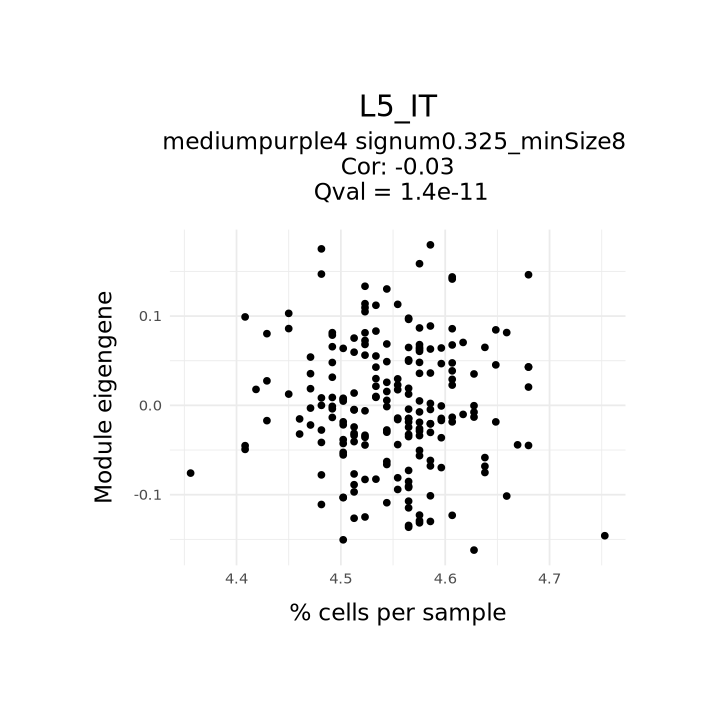

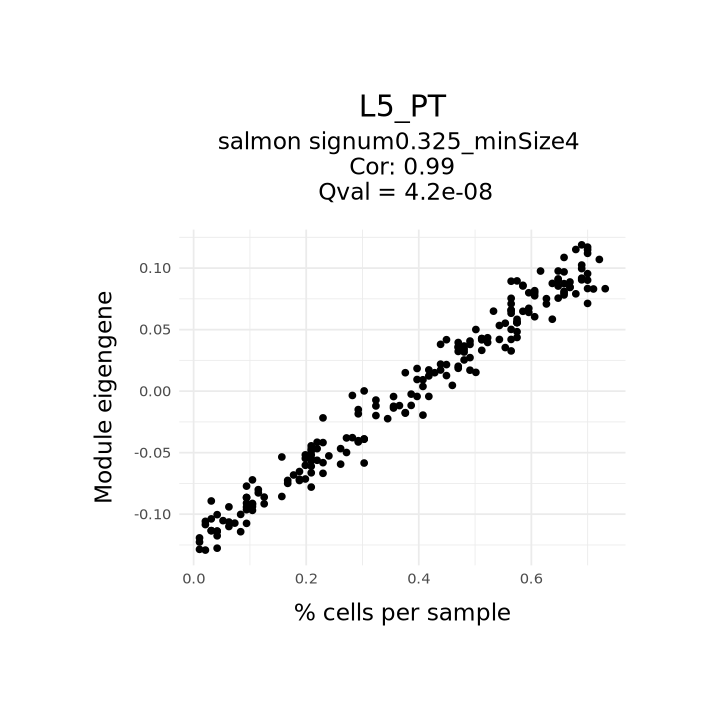

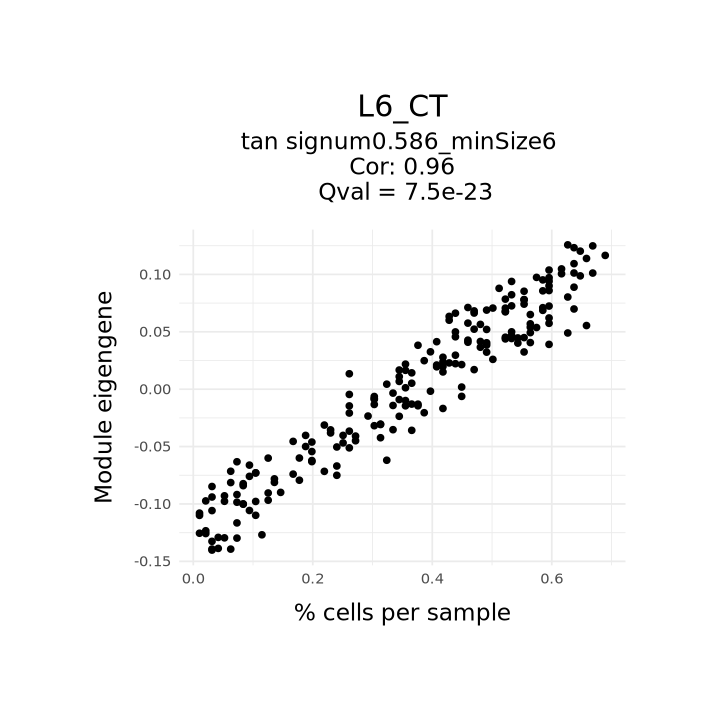

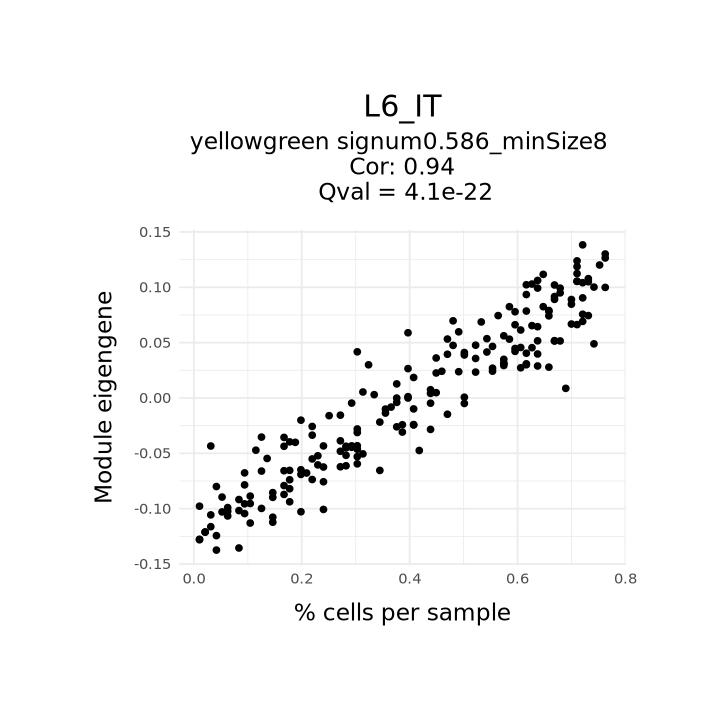

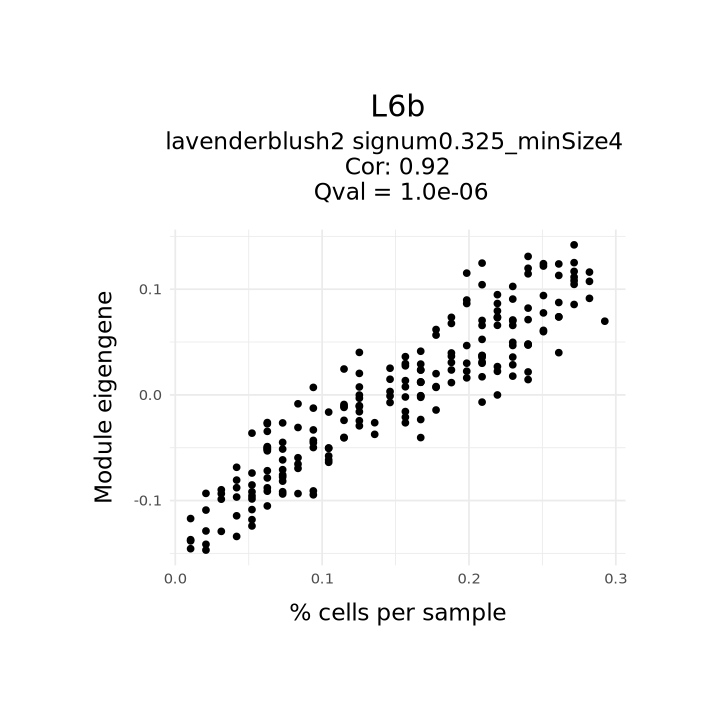

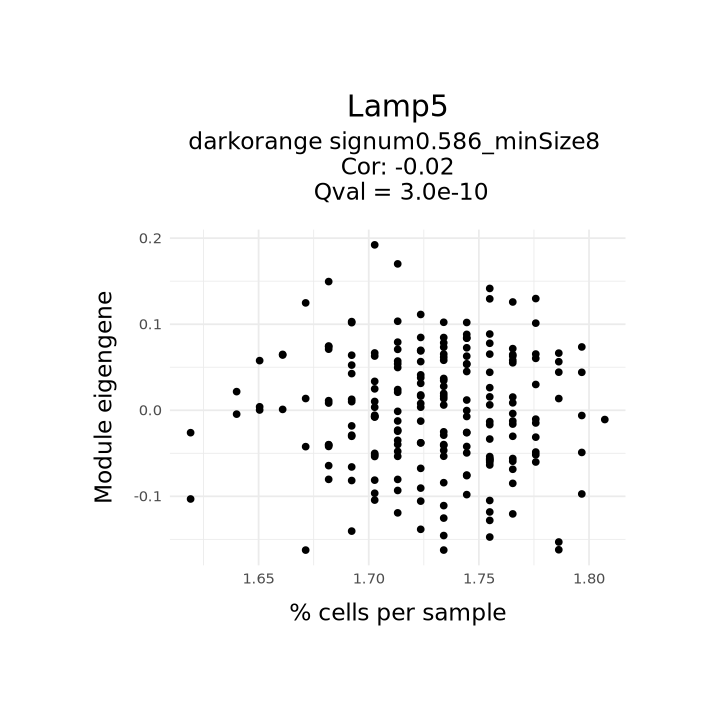

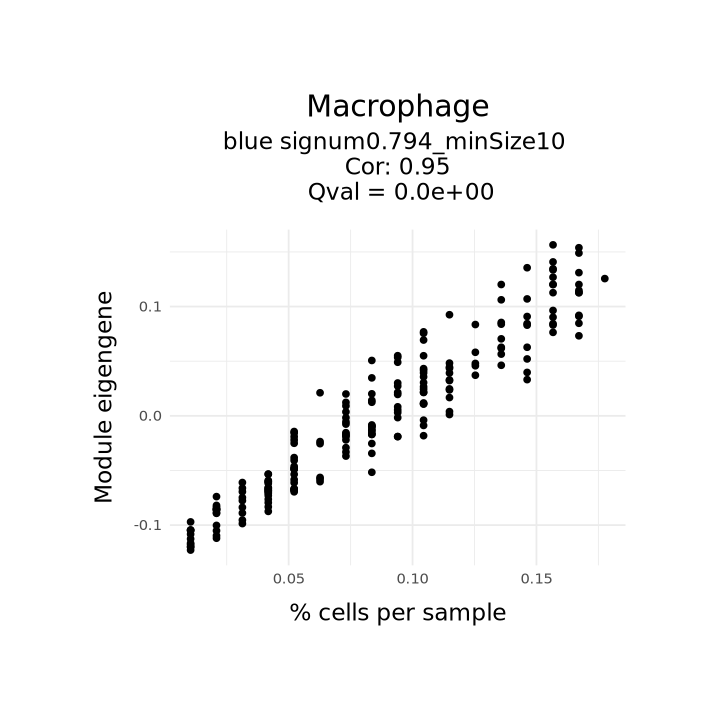

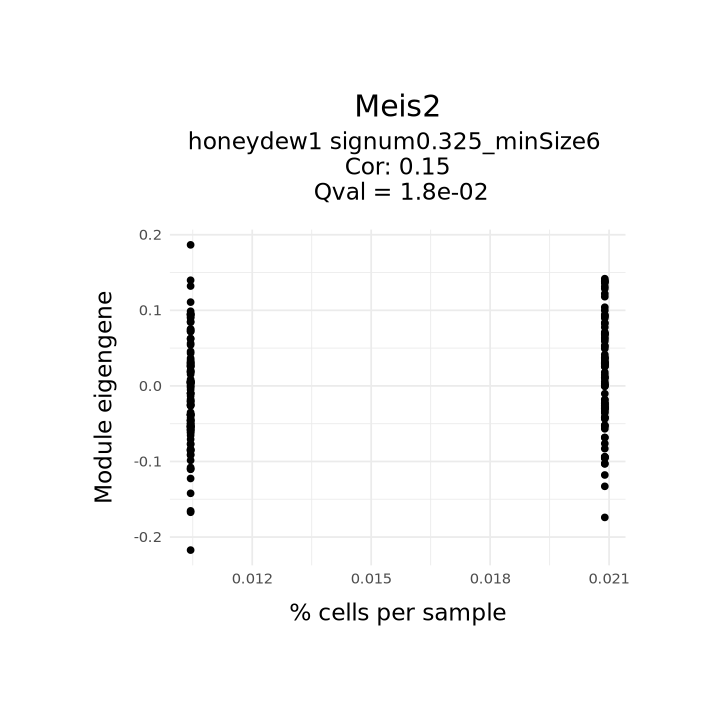

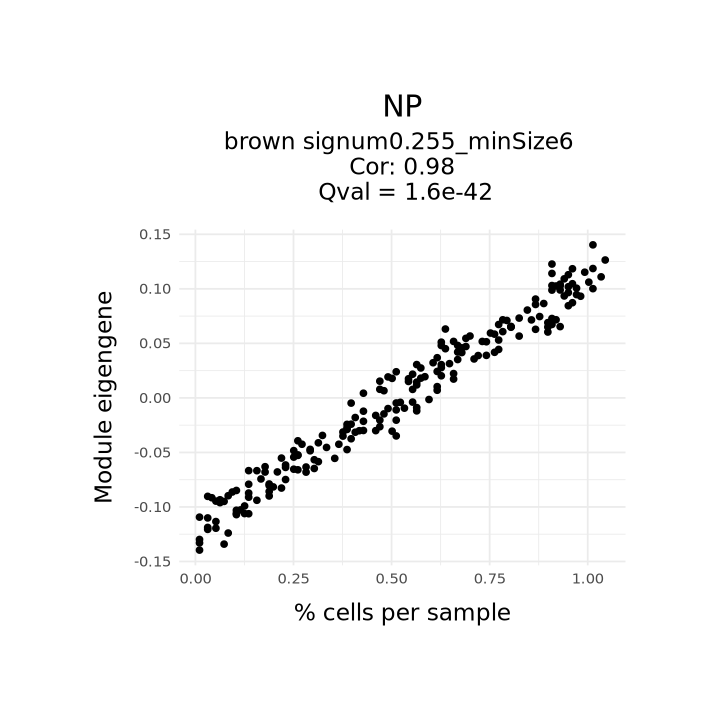

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


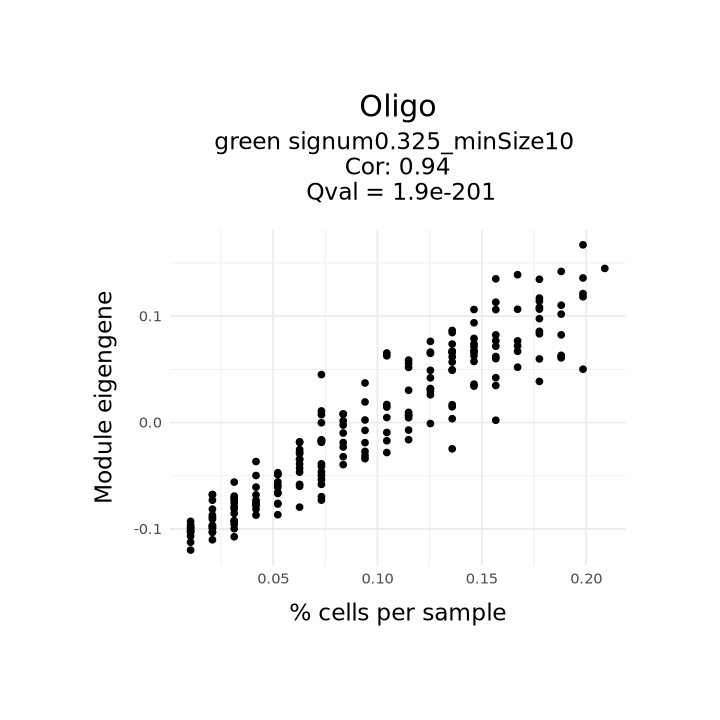

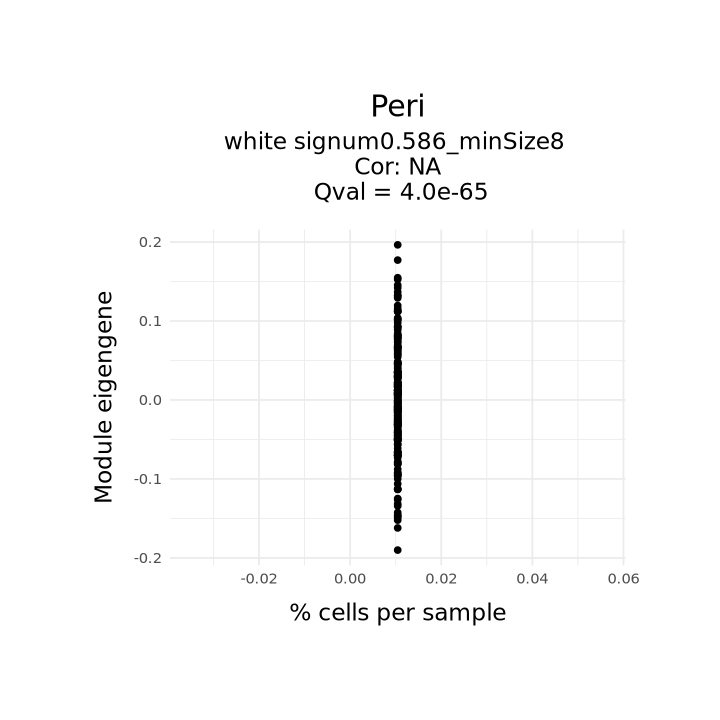

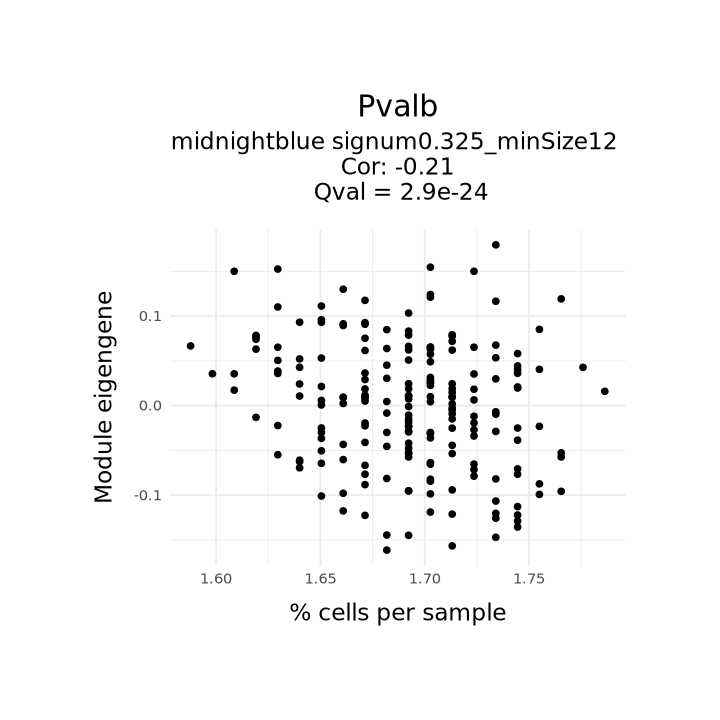

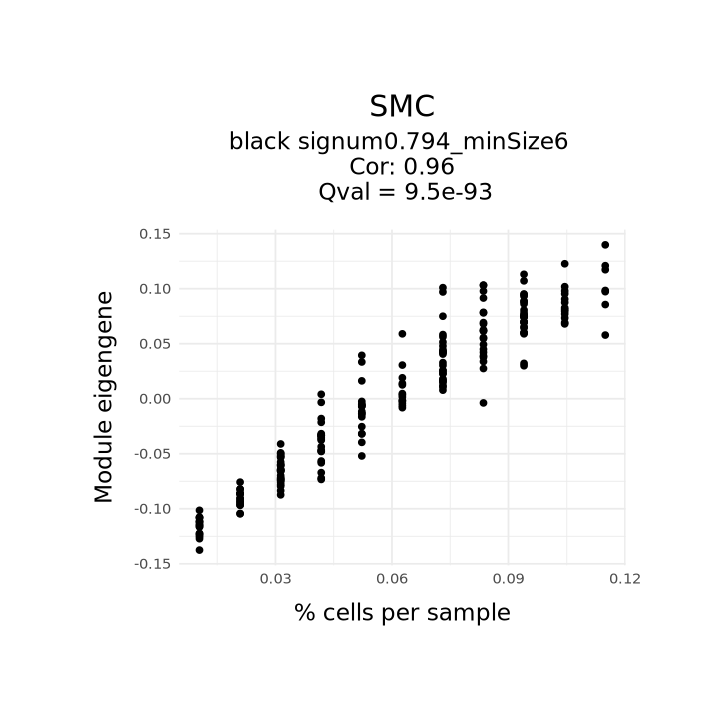

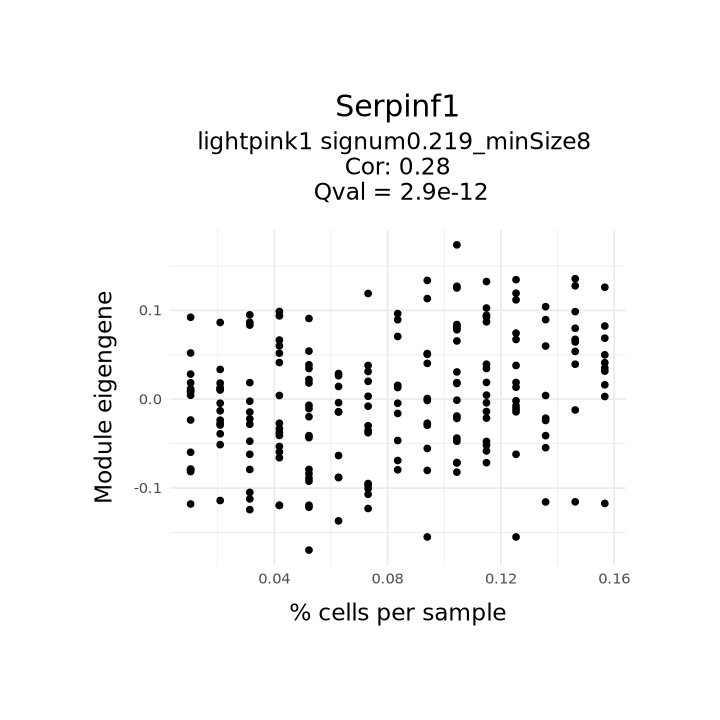

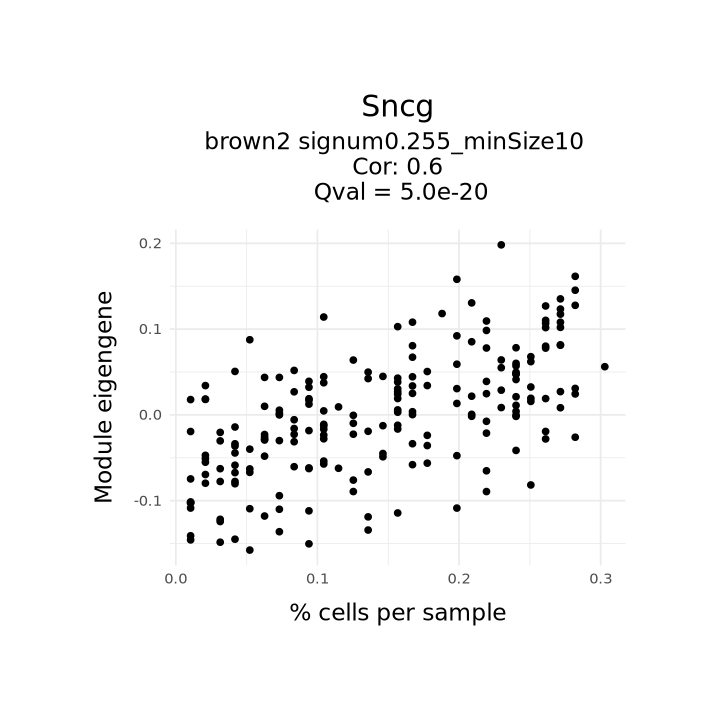

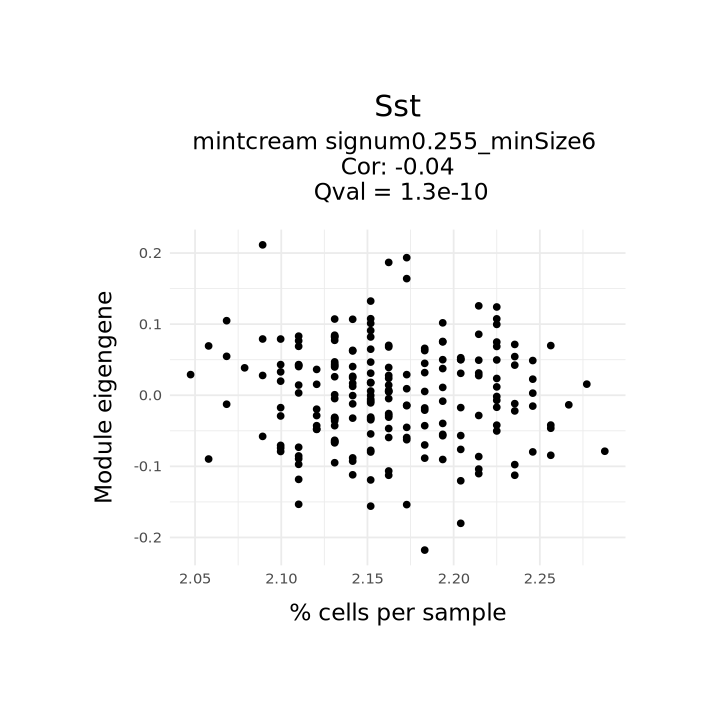

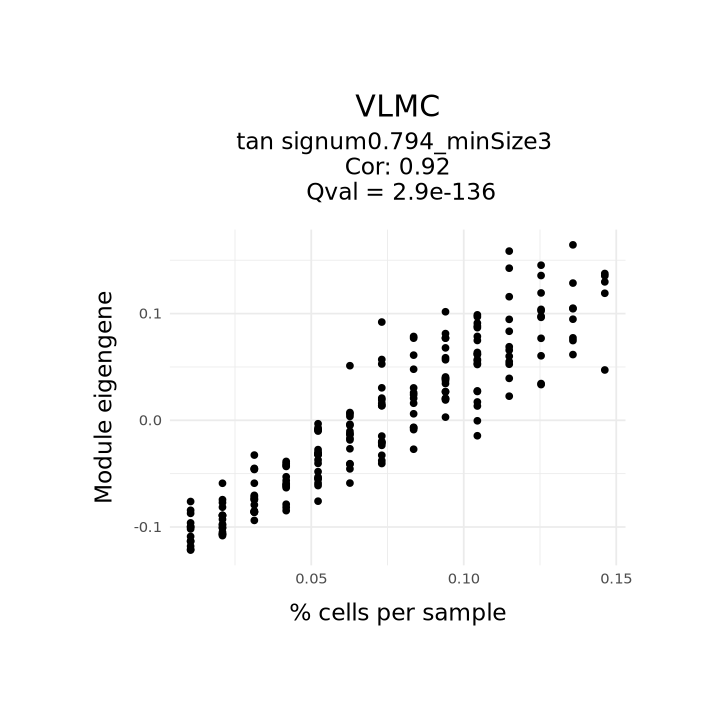

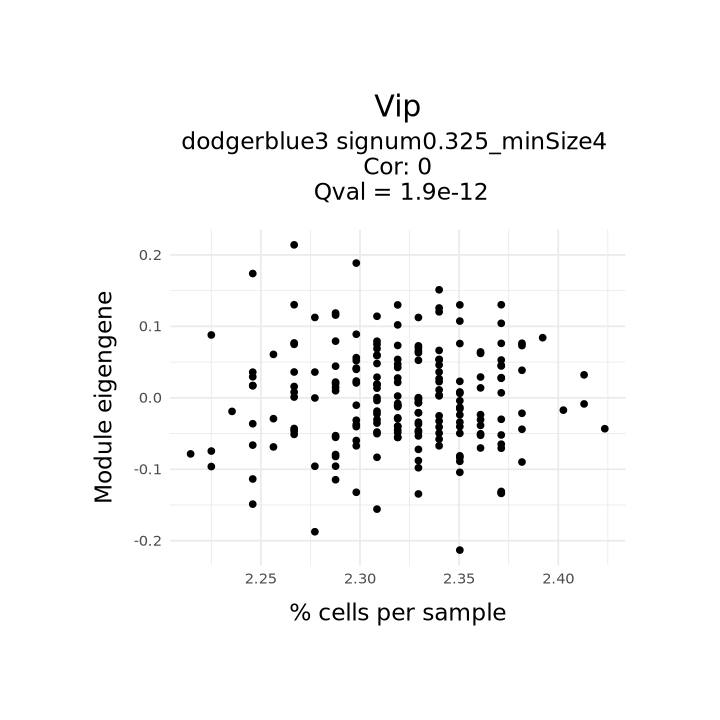

In [97]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [98]:
top_corr_mods_0.4pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_0.4pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
orange2,Lamp5,0.1939443,-0.022435143,orange2,darkorange,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.586_minSize8_merge_ME_0.9_20151,3.46,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151/Module_eigengenes_08-09-19.csv
gray53,Sst,0.2001982,-0.042783507,gray53,mintcream,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.255_minSize6_merge_ME_0.9_20151,4.61,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
gray58,Vip,0.2119883,-0.004228451,gray58,dodgerblue3,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,3.84,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
orchid,CR,0.2291747,0.129101599,orchid,mistyrose1,Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-18-43.csv
lightsalmon3,Pvalb,0.2500620,-0.213812093,lightsalmon3,midnightblue,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize12_merge_ME_0.9_20151,3.74,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151/Module_eigengenes_08-09-19.csv
gray4,Meis2,0.2845981,0.149229893,gray4,honeydew1,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize6_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
darkkhaki,L5_IT,0.2855019,-0.034604339,darkkhaki,mediumpurple4,Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.325_minSize8_merge_ME_0.9_20151,5.73,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-44-39.csv
dodgerblue1,Serpinf1,0.7316211,0.276181507,dodgerblue1,lightpink1,Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.219_minSize8_merge_ME_0.9_20151,4.20,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151/Module_eigengenes_08-09-19.csv
darkorchid2,Sncg,0.8643323,0.598679043,darkorchid2,brown2,Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151,8.13,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-18-43.csv


# Round 4 (50% var network; PosBC module definition)

In [99]:
network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [100]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [101]:
top_corr_mods_50pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_50pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
pink1,Sncg,0.1320302,0.08311361,pink1,lightcyan,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.629_minSize6_merge_ME_0.9_20151,10.18,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-51-01.csv
skyblue2,CR,0.1490367,-0.04376170,skyblue2,peru,Bicor-None_signum0.629_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,0.79,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.629_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-17-00.csv
orange1,Meis2,0.1785107,-0.08011696,orange1,antiquewhite4,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.629_minSize8_merge_ME_0.9_20151,0.74,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-57-01.csv
palevioletred4,Peri,0.1873673,-0.16100388,palevioletred4,blue,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.968_minSize3_merge_ME_0.9_20151,0.73,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-51-01.csv
lightgoldenrod4,Serpinf1,0.1938398,0.07748015,lightgoldenrod4,salmon,Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,5.23,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-51-01.csv
mintcream,L4,0.2015220,0.07698462,mintcream,lightpink3,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.465_minSize10_merge_ME_0.9_20151,0.70,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-57-01.csv
mistyrose1,L6_IT,0.7960936,0.69452226,mistyrose1,darkorange2,Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151,25.63,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-57-01.csv
darkolivegreen,VLMC,0.8453615,0.83210083,darkolivegreen,orange,Bicor-None_signum0.629_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.629_minSize8_merge_ME_0.9_20151,5.17,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.629_minSize10_merge_ME_0.9_20151/Module_eigengenes_07-48-32.csv
darkorange,Oligo,0.8554086,0.82541326,darkorange,darkturquoise,Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.928_minSize3_merge_ME_0.9_20151,7.05,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151/Module_eigengenes_07-08-21.csv


In [102]:
# plot_ctype_abundance(pseudobulk_legend)

# Round 5 (50% var network; PosFDR module definition)

In [103]:
# network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [104]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [105]:
# top_corr_mods_50pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_50pcnt_PosFDR_df

# Round 6 (10% var network, PosFDR module definition)

In [106]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [107]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [108]:
# top_corr_mods_10pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_10pcnt_PosFDR_df

# Round 7 (10% var network, PosBC module definition)

In [109]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [110]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [111]:
top_corr_mods_10pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_10pcnt_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
rosybrown3,VLMC,0.2176395,0.09400113,rosybrown3,darkslateblue,Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.539_minSize4_merge_ME_0.9_20151,1.24,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-11-49.csv
yellow1,Serpinf1,0.2191469,0.04851468,yellow1,floralwhite,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize4_merge_ME_0.9_20151,1.60,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-09-50.csv
greenyellow,Meis2,0.2200408,0.02326452,greenyellow,antiquewhite,Bicor-None_signum0.349_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize10_merge_ME_0.9_20151/Module_eigengenes_06-51-46.csv
lightgoldenrod4,Sncg,0.2376732,0.11588496,lightgoldenrod4,orangered4,Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize6_merge_ME_0.9_20151,2.37,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-11-49.csv
steelblue3,CR,0.2723505,0.12232763,steelblue3,gray2,Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,0.50,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151/Module_eigengenes_08-11-49.csv
plum2,Oligo,0.3083297,0.10097966,plum2,grey60,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.539_minSize6_merge_ME_0.9_20151,1.61,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-09-50.csv
royalblue,SMC,0.3581447,0.35386647,royalblue,purple,Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151,1.14,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151/Module_eigengenes_05-57-34.csv
magenta3,L6_IT,0.3912662,0.37324554,magenta3,hotpink3,Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize4_merge_ME_0.9_20151,4.70,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-00-38.csv
palevioletred4,L6_CT,0.4346011,0.42529993,palevioletred4,gray15,Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.173_minSize5_merge_ME_0.9_20151,3.86,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151/Module_eigengenes_06-09-50.csv


# Round 8 (kappa = 25 network, PosBC module definition)

In [112]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

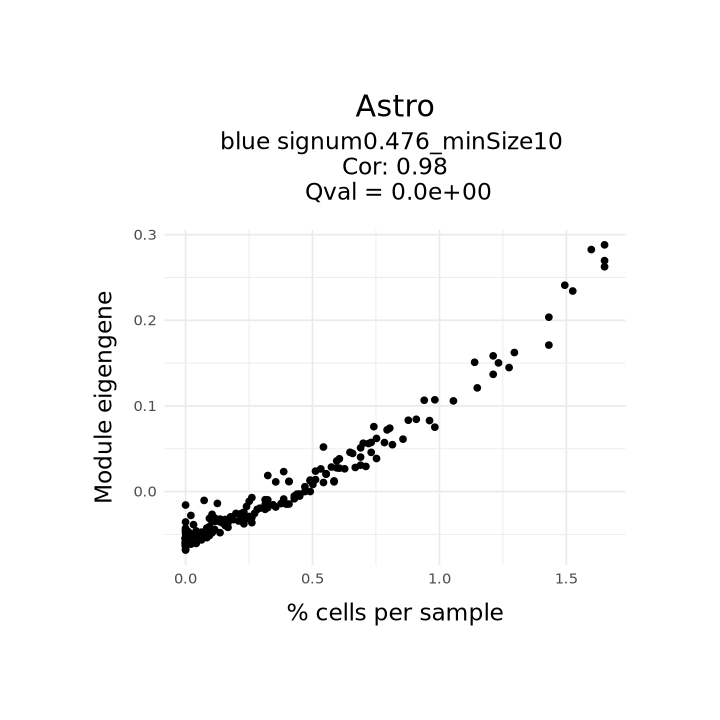

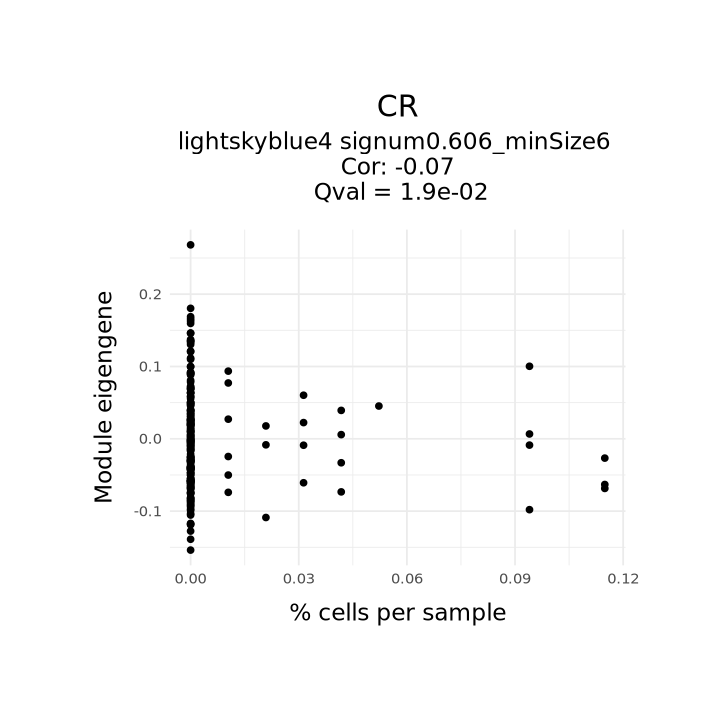

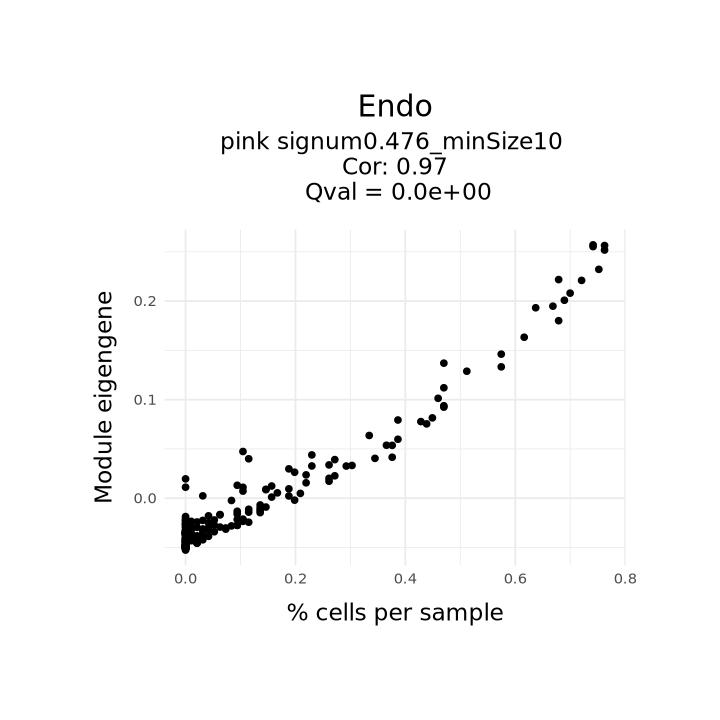

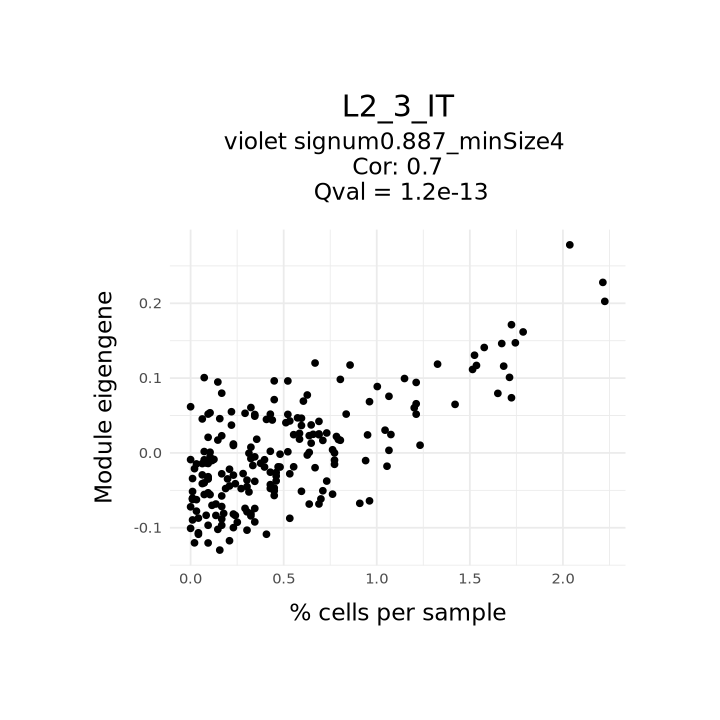

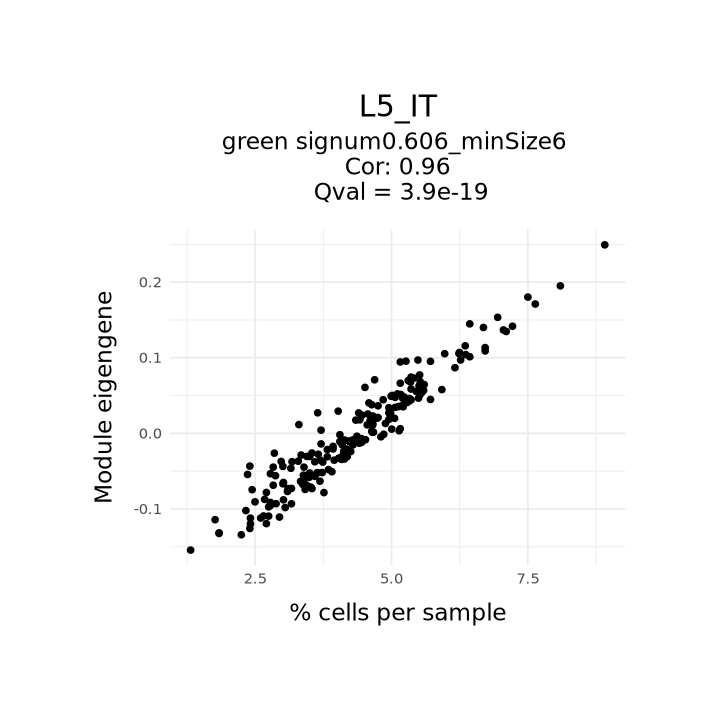

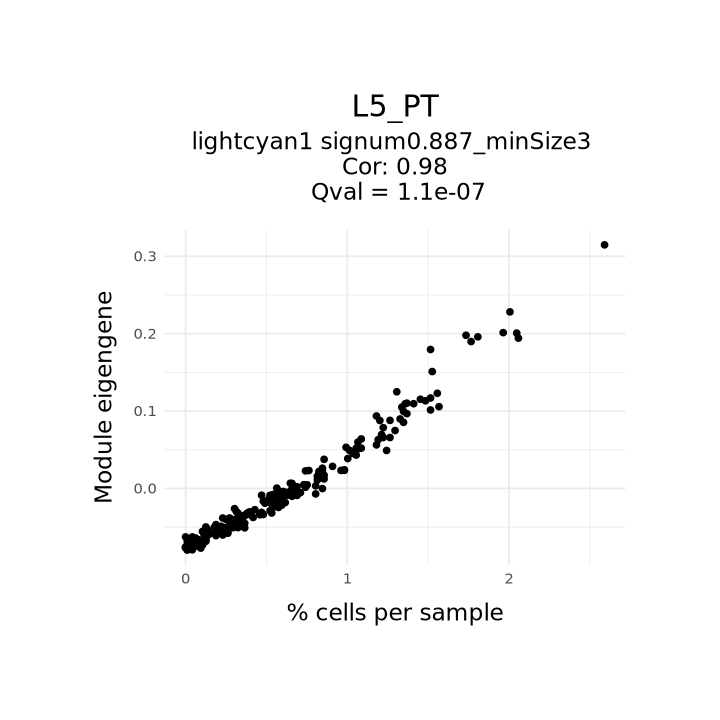

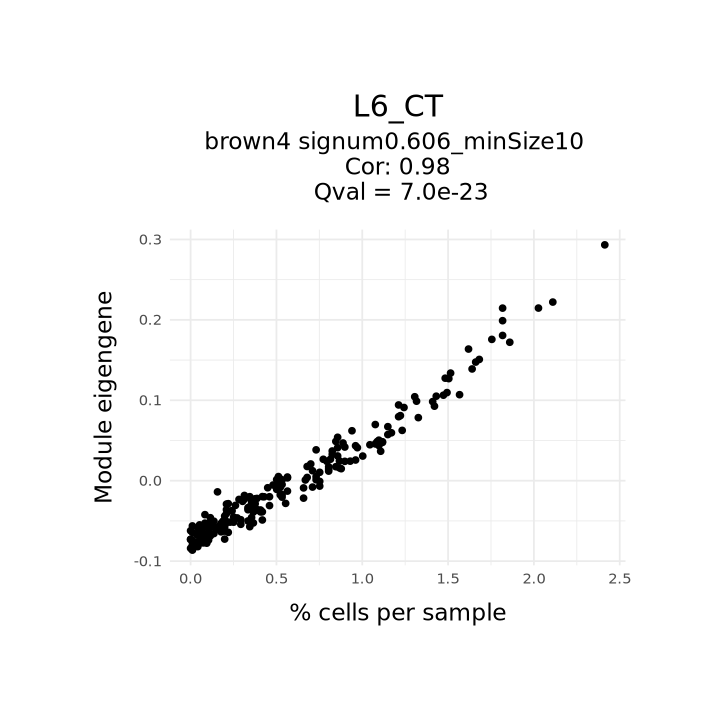

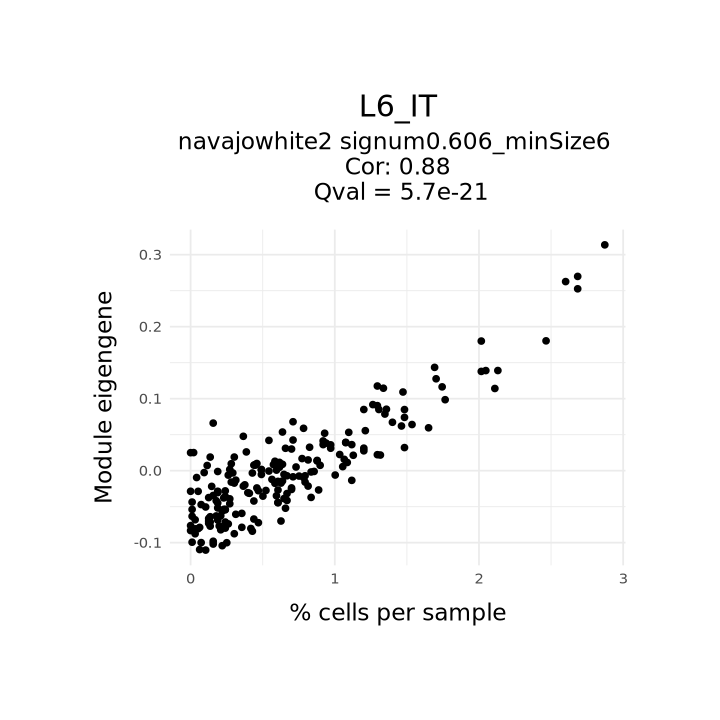

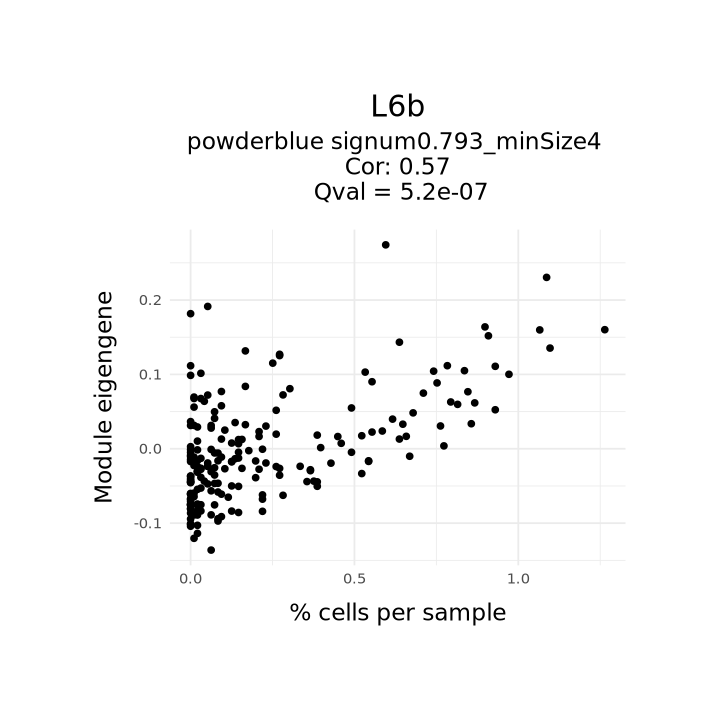

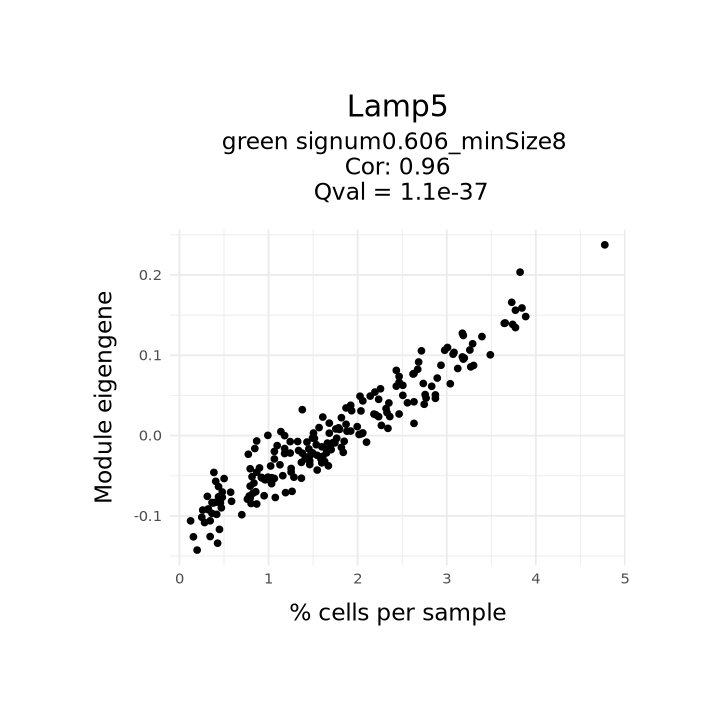

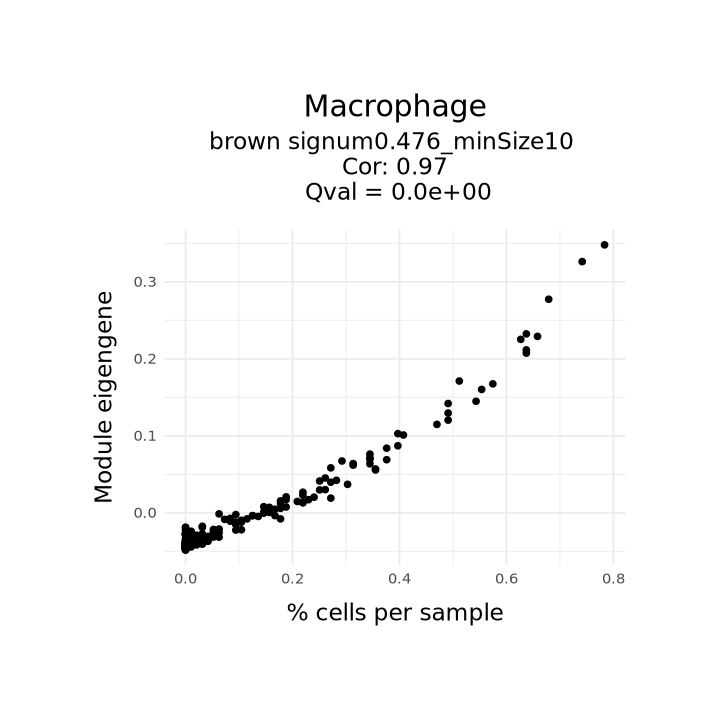

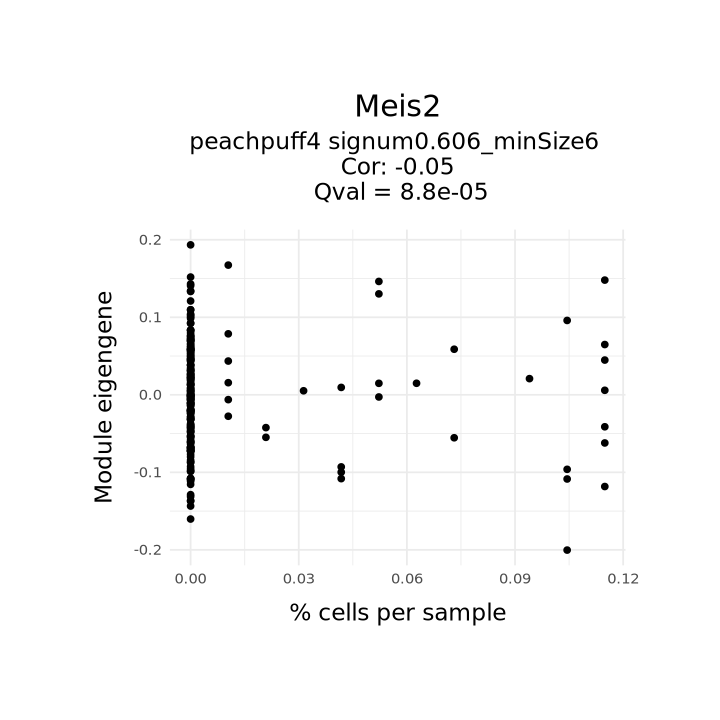

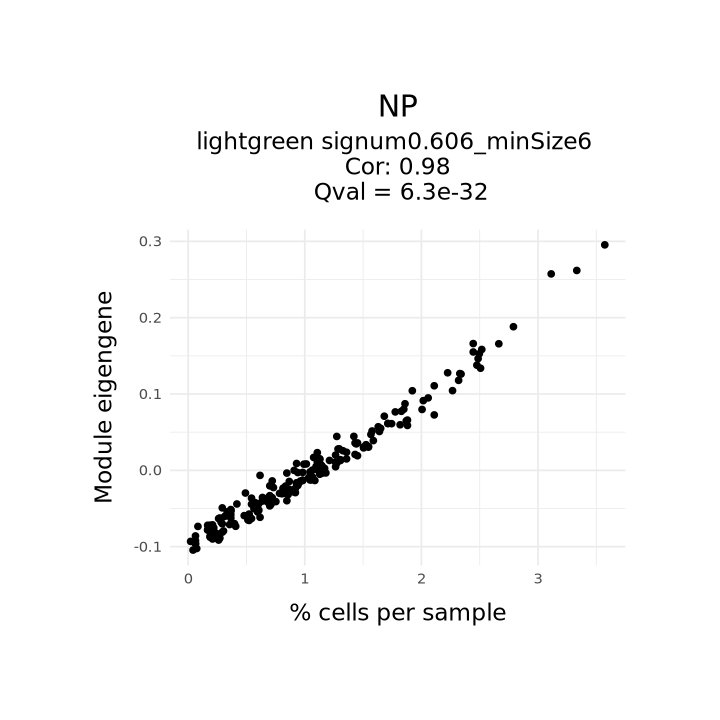

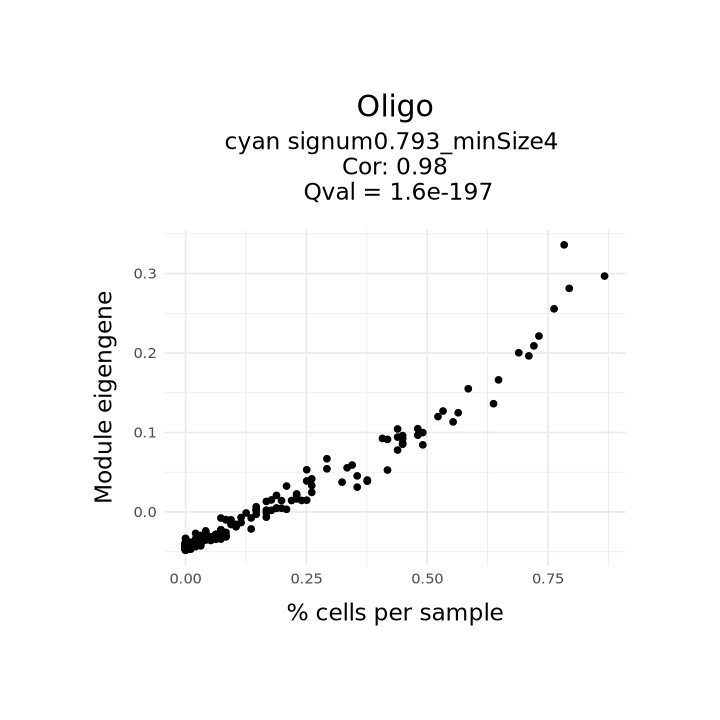

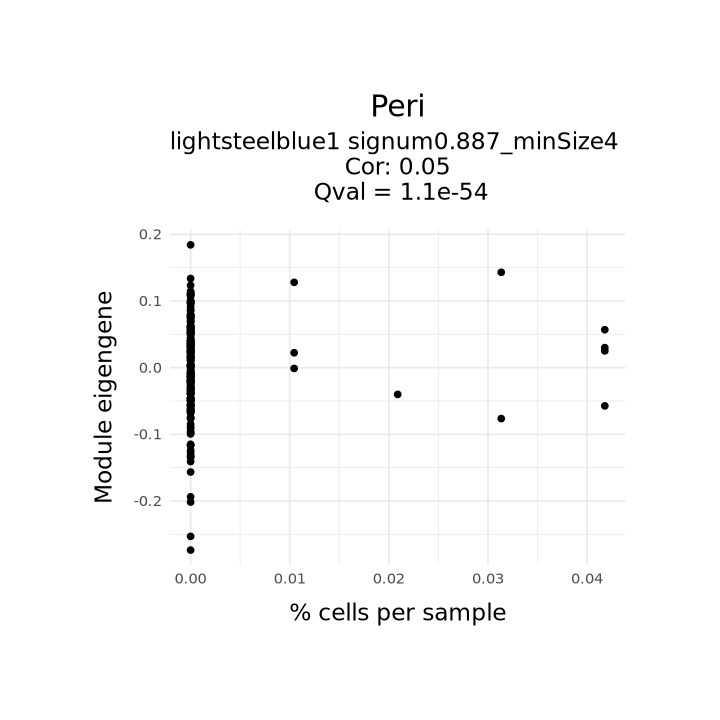

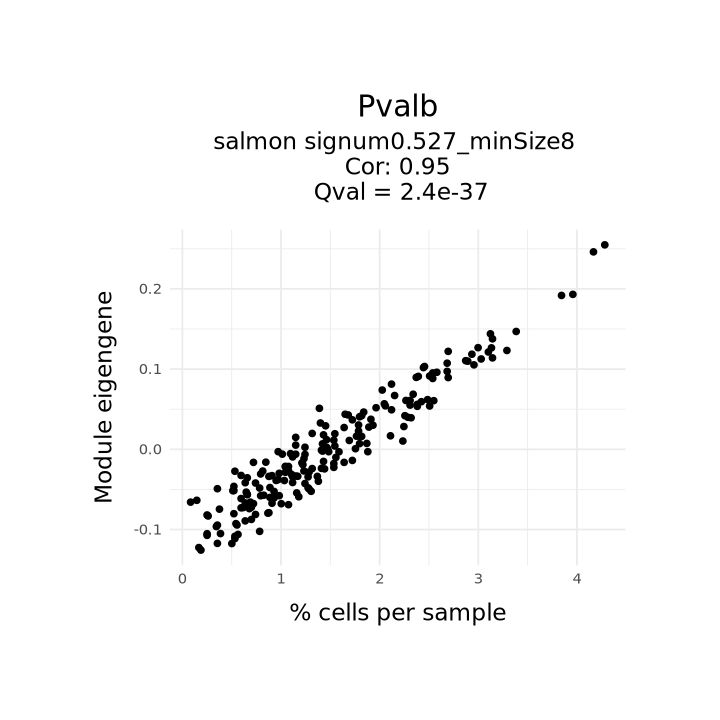

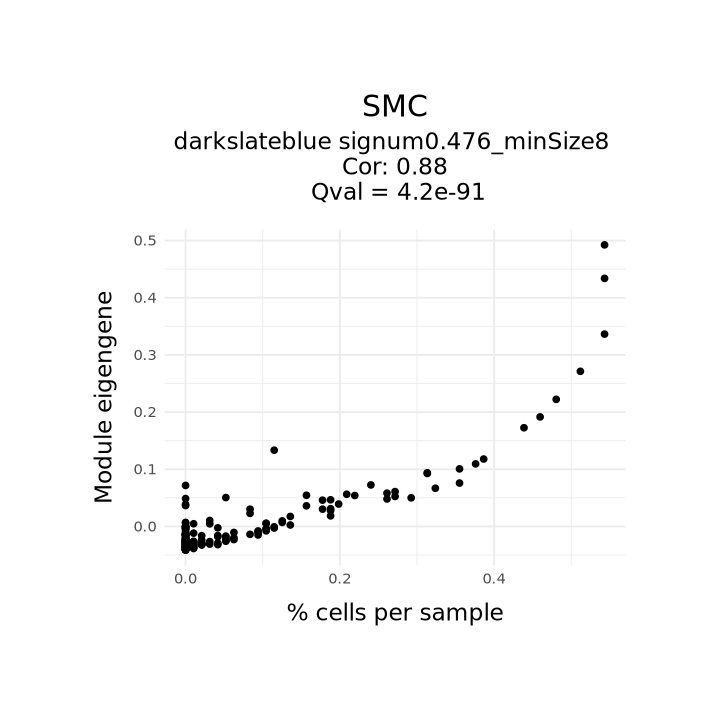

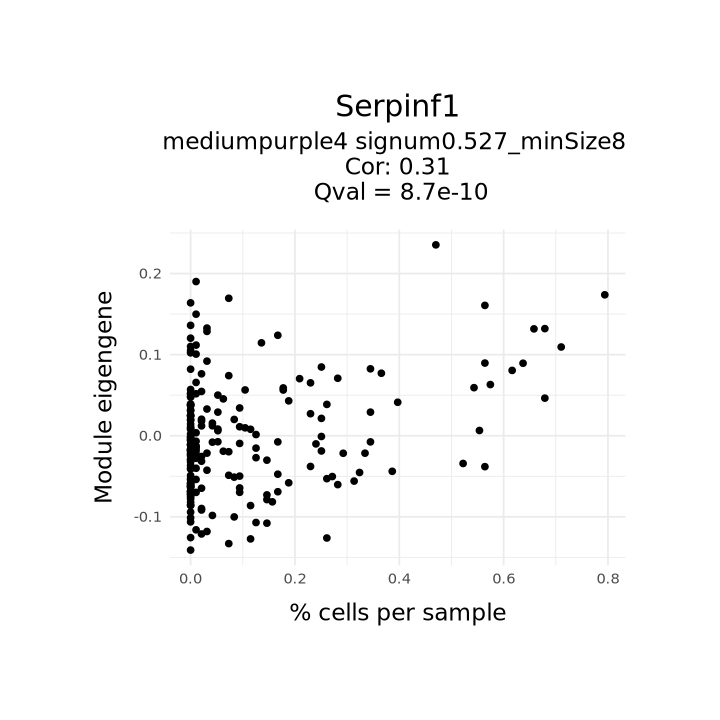

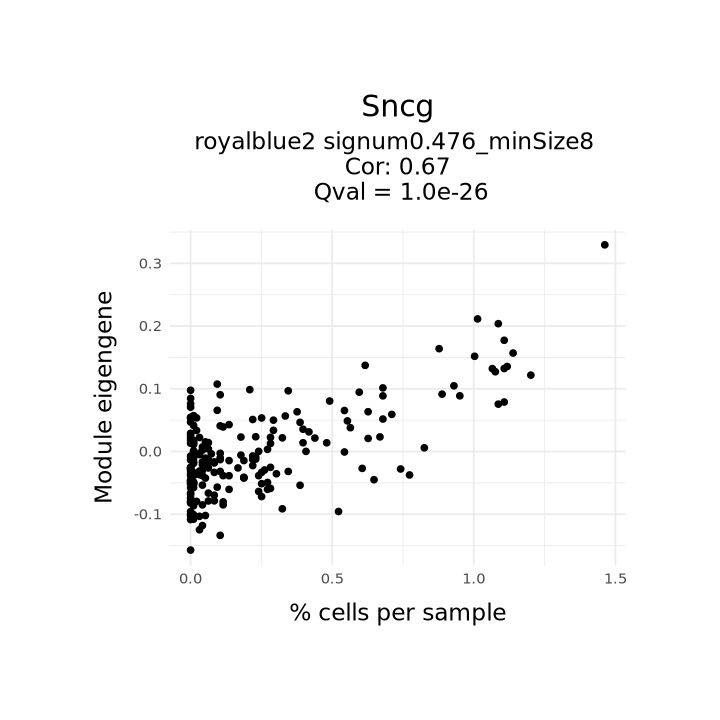

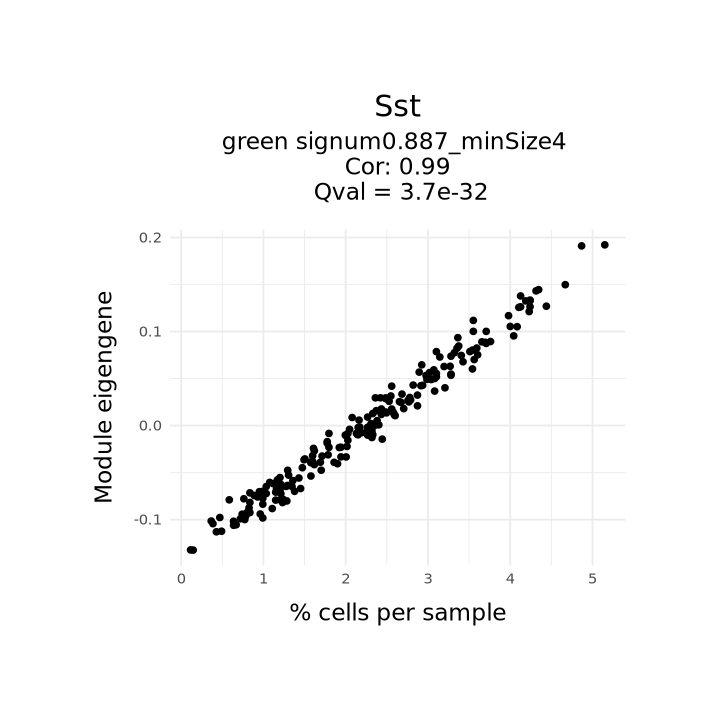

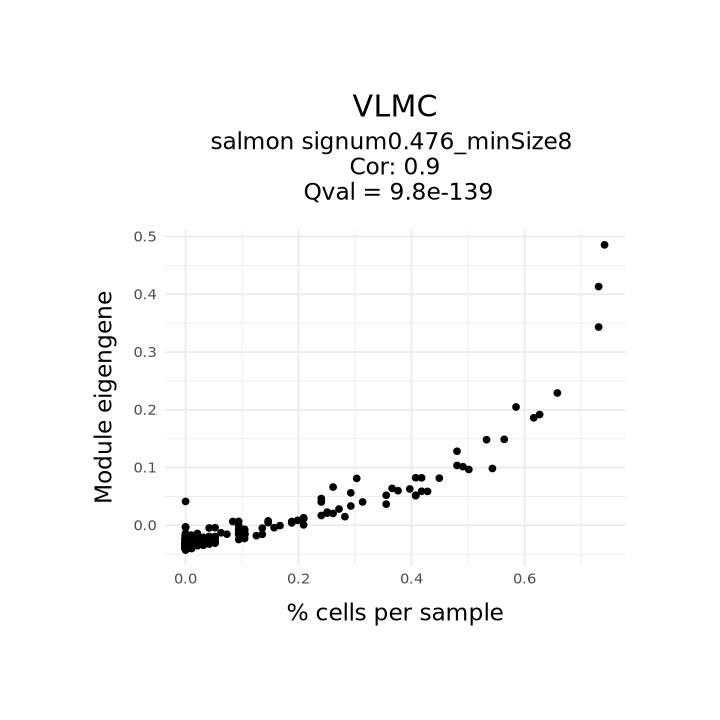

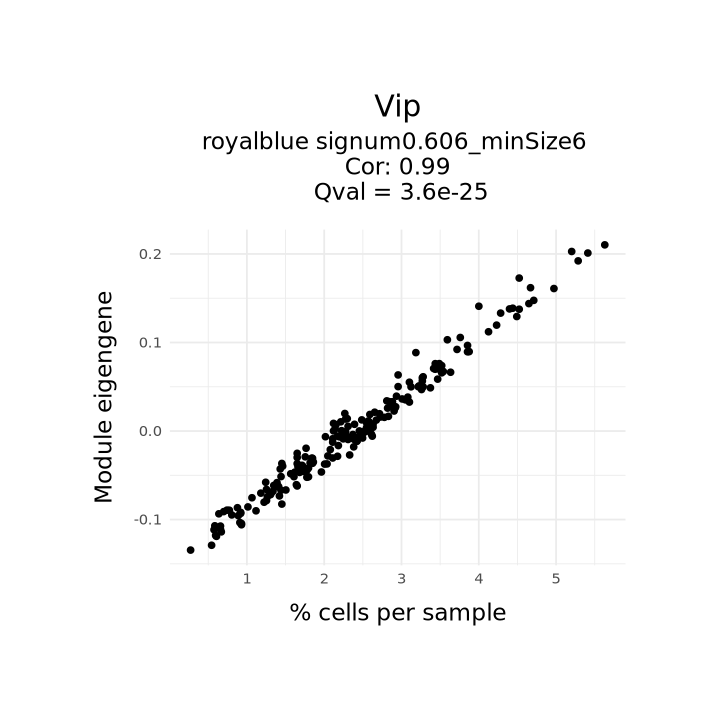

In [113]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [114]:
top_corr_mods_25kappa_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_25kappa_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
navajowhite1,Peri,0.1932410,0.05267446,navajowhite,lightsteelblue1,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.887_minSize4_merge_ME_0.9_20151,0.65,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-40-41.csv
firebrick1,CR,0.2303541,-0.06763805,firebrick1,lightskyblue4,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,1.96,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
brown3,Meis2,0.3125991,-0.05137787,brown3,peachpuff4,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,2.71,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
honeydew,Serpinf1,0.4026167,0.30979272,honeydew,mediumpurple4,Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.527_minSize8_merge_ME_0.9_20151,16.64,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151/Module_eigengenes_10-31-35.csv
powderblue,L6b,0.5722537,0.57225369,powderblue,powderblue,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,27.72,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-40-41.csv
firebrick11,Sncg,0.6889803,0.66953336,firebrick1,royalblue2,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,30.88,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
darkslateblue,SMC,0.8800080,0.88000800,darkslateblue,darkslateblue,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,11.55,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151/Module_eigengenes_11-56-44.csv
ivory,L6_IT,0.9108326,0.87961021,ivory,navajowhite2,Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,56.24,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151/Module_eigengenes_10-47-45.csv
palevioletred3,VLMC,0.9117353,0.90136592,palevioletred3,salmon,Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,16.84,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-52-27.csv


# Round 9 (kappa = 25 network, PosBC module definition; merge param = 0.85)

In [115]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_mergeParam0.85_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_log2_pseudobulk_mergeParam0.85_PosBC_top_Qval_modules.csv")

In [116]:
# top_corr_mods_25kappa_merge0.85_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_25kappa_merge0.85_PosBC_df

# Round 9 (kappa = 25 network, PosBC module definition; no log2 transform)

In [117]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_pseudobulk_PosBC_top_Qval_modules.csv")

In [118]:
# top_corr_mods_25kappa_nolog_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_25kappa_nolog_PosBC_df

In [119]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Round 10 (40% var network w/ bug fixed, PosBC module definition)

# Round 11 (15 kappa, PosBC module definition)

In [120]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_15kappa_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_15kappa_200samples_legend_09-54-59.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_15kappa_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [121]:
# top_corr_mods_15kappa_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_15kappa_PosBC_df

In [122]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Round 12 (25 kappa, PosBC module definition; non-unique pairwise DE genes)

In [123]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_pairwise_DE_genes_dream_20pcntCells_25kappa_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv") 

In [124]:
top_corr_mods_25kappa_PosBC_pairwise_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_25kappa_PosBC_pairwise_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
navajowhite1,Peri,0.1932410,0.09161543,navajowhite,orange3,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,0.65,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-40-41.csv
honeydew,Serpinf1,0.4026167,0.30979272,honeydew,mistyrose,Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,16.64,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151/Module_eigengenes_10-31-35.csv
powderblue,L6b,0.5722537,0.38889139,powderblue,orange,Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.941_minSize3_merge_ME_0.9_20151,27.72,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-40-41.csv
firebrick1,Sncg,0.6889803,0.66953336,firebrick1,royalblue2,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,30.88,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-58-48.csv
darkslateblue,SMC,0.8800080,0.88000800,darkslateblue,darkslateblue,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,11.55,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151/Module_eigengenes_11-56-44.csv
ivory,L6_IT,0.9108326,0.87961021,ivory,navajowhite2,Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,56.24,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151/Module_eigengenes_10-47-45.csv
palevioletred3,VLMC,0.9117353,0.90136592,palevioletred3,salmon,Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151,Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151,16.84,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151/Module_eigengenes_10-52-27.csv
burlywood,L2_3_IT,0.9793319,0.70228174,burlywood,violet,Bicor-None_signum0.476_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.887_minSize4_merge_ME_0.9_20151,45.91,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.476_minSize10_merge_ME_0.9_20151/Module_eigengenes_12-20-21.csv
yellow4,L5_IT,0.9793463,0.95661023,yellow,green,Bicor-None_signum0.941_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151,122.86,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.941_minSize4_merge_ME_0.9_20151/Module_eigengenes_10-29-28.csv


In [125]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Round 13 (20 SD, PosBC module definition)

In [126]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_20SD_200samples_legend_11-47-32.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_20SD_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv") 

In [127]:
top_corr_mods_20SD_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_20SD_PosBC_df

,Cell_type,Cor,Old_cor,Module,Old_module,Network,Old_network,Pseudobulk_SD,New_ME_path
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
violet,L5_IT,0.4687455,0.45090311,violet,steelblue,Bicor-None_signum0.719_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize6_merge_ME_0.9_20151,17.49,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.719_minSize3_merge_ME_0.9_20151/Module_eigengenes_05-41-21.csv
plum,L4,0.7112359,0.13406661,plum,mistyrose4,Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.349_minSize5_merge_ME_0.9_20151,0.95,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151/Module_eigengenes_09-38-44.csv
coral3,Vip,0.7487778,0.64479322,coral3,coral3,Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.434_minSize6_merge_ME_0.9_20151,18.19,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151/Module_eigengenes_09-38-44.csv
pink3,Peri,0.7633242,-0.10484858,pink,purple,Bicor-None_signum0.898_minSize3_merge_ME_0.9_20151,Bicor-None_signum0.719_minSize10_merge_ME_0.9_20151,1.40,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.898_minSize3_merge_ME_0.9_20151/Module_eigengenes_05-37-20.csv
palevioletred,Pvalb,0.7654772,0.52125363,palevioletred,coral4,Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.434_minSize8_merge_ME_0.9_20151,14.97,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151/Module_eigengenes_09-38-44.csv
floralwhite,Sst,0.7682868,0.76828682,floralwhite,brown4,Bicor-None_signum0.434_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.434_minSize4_merge_ME_0.9_20151,16.52,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.434_minSize10_merge_ME_0.9_20151/Module_eigengenes_07-05-22.csv
blueviolet,Lamp5,0.7883484,0.59683524,blueviolet,lightpink4,Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.719_minSize4_merge_ME_0.9_20151,17.20,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.301_minSize10_merge_ME_0.9_20151/Module_eigengenes_09-38-44.csv
green1,L6_IT,0.8638238,0.73370147,green1,khaki4,Bicor-None_signum0.434_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.719_minSize3_merge_ME_0.9_20151,17.08,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.434_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-02-40.csv
lightblue4,Meis2,0.8696402,-0.02047965,lightblue4,cyan,Bicor-None_signum0.434_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.898_minSize3_merge_ME_0.9_20151,3.91,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_20SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.434_minSize4_merge_ME_0.9_20151/Module_eigengenes_06-02-40.csv


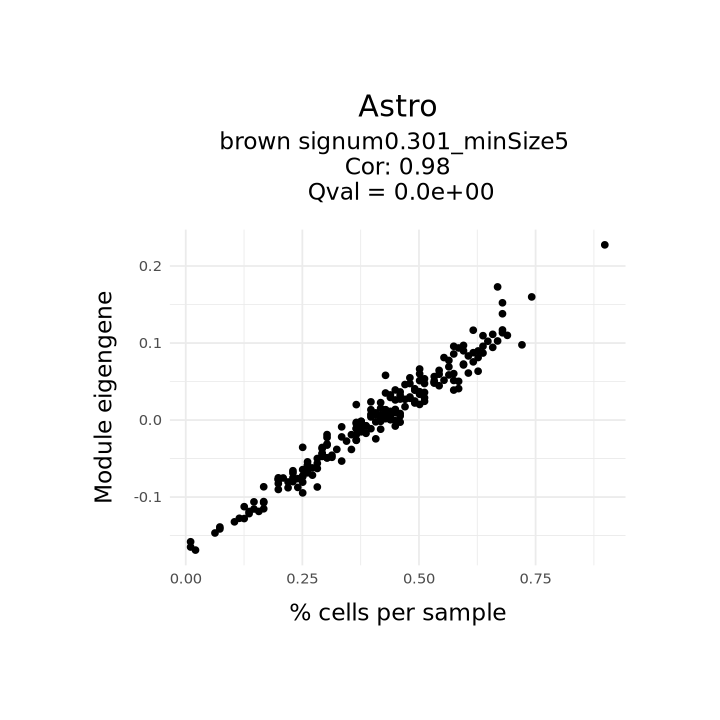

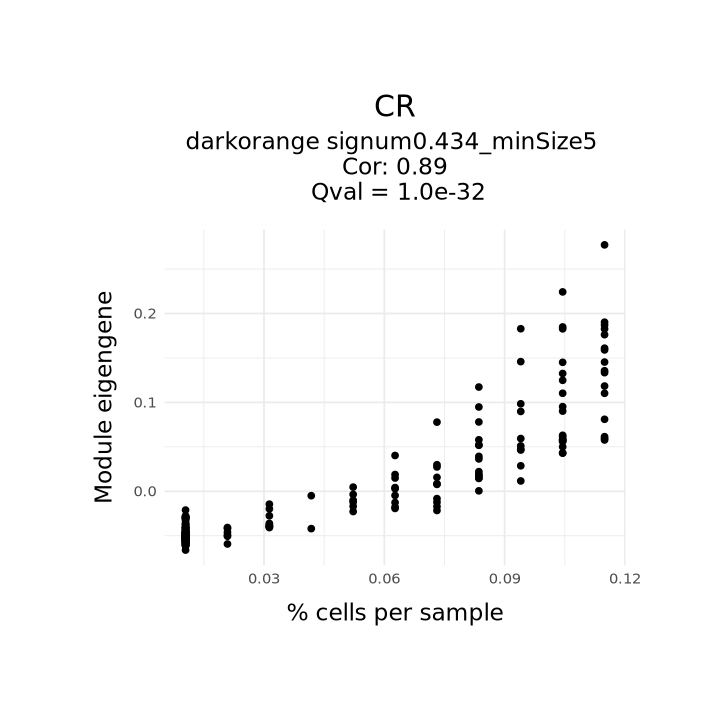

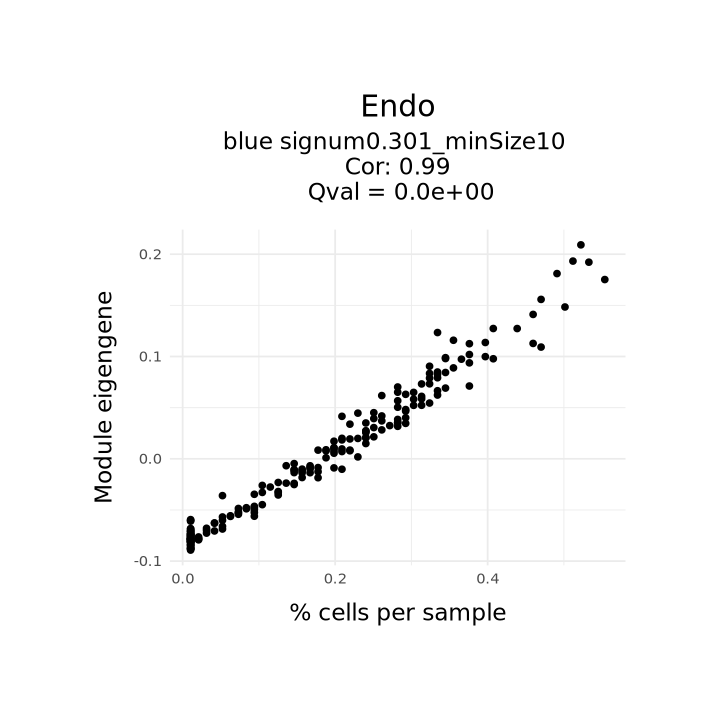

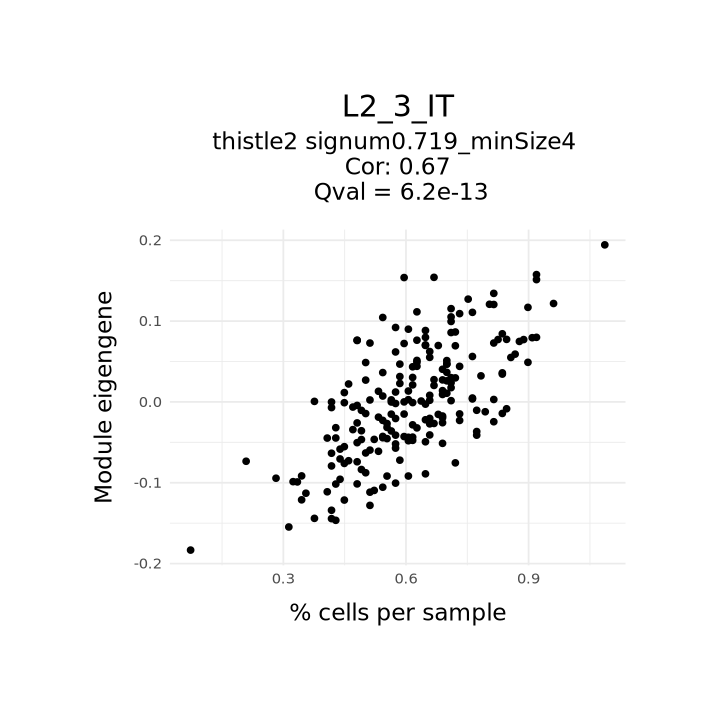

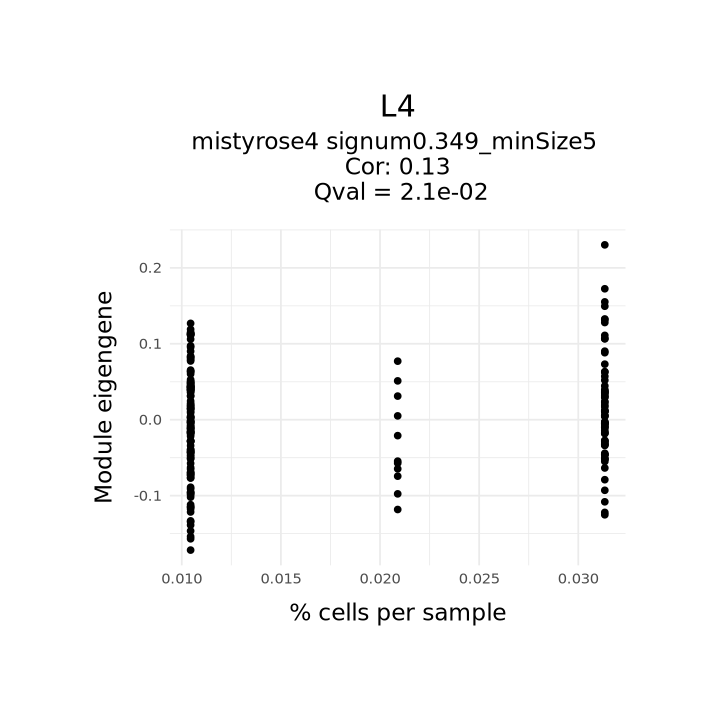

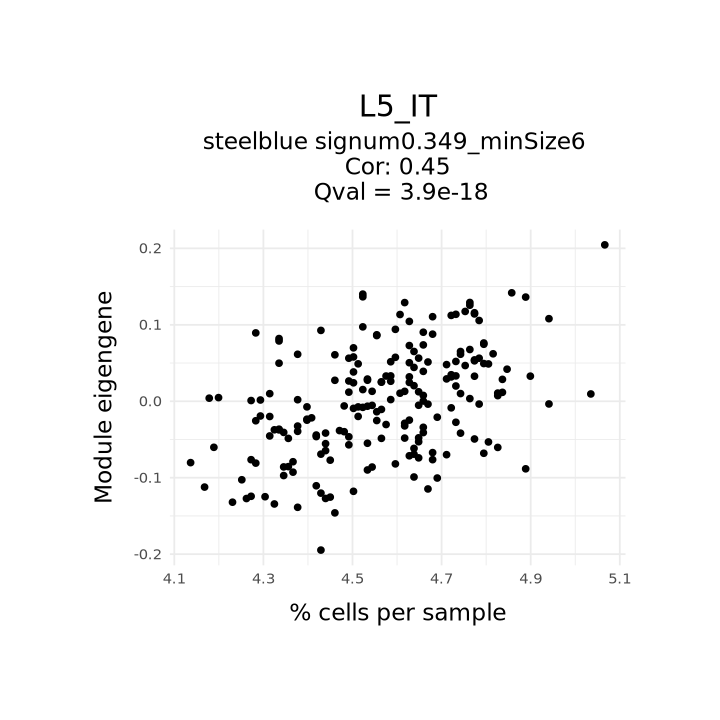

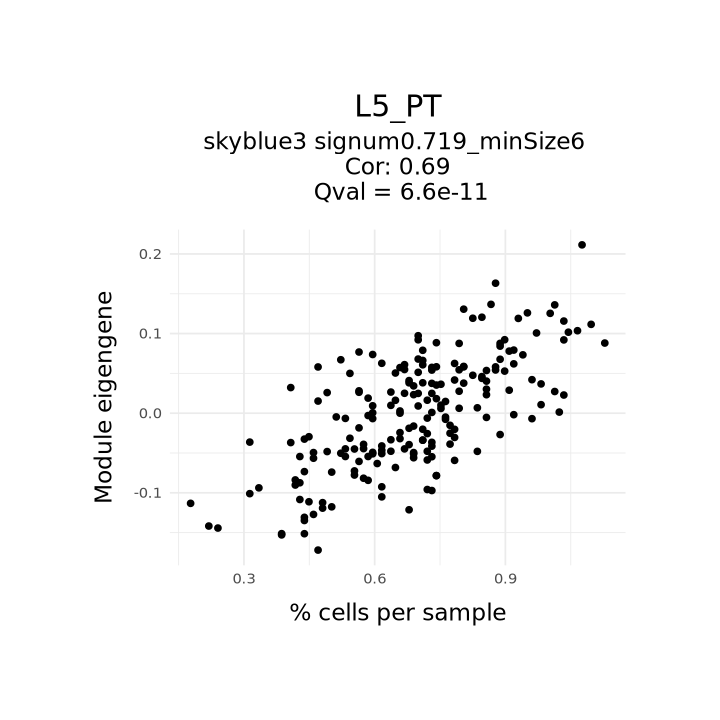

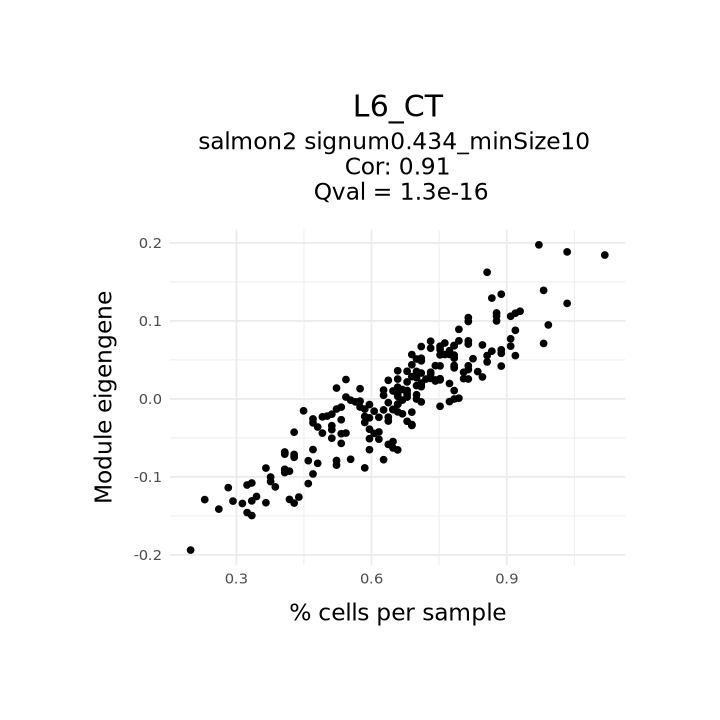

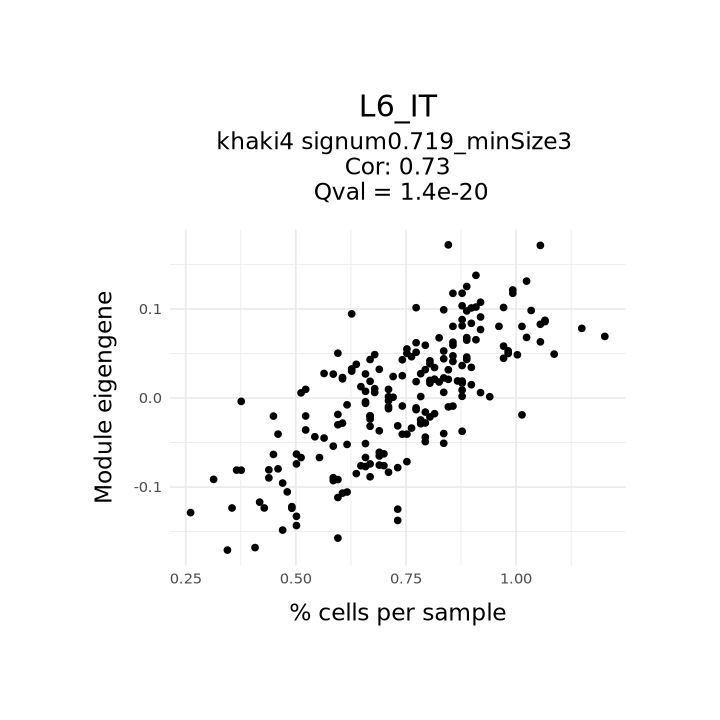

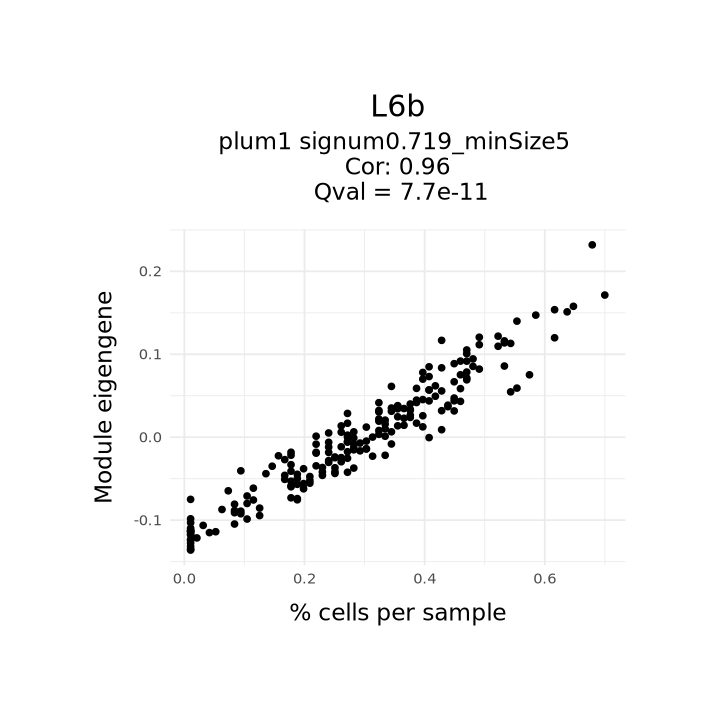

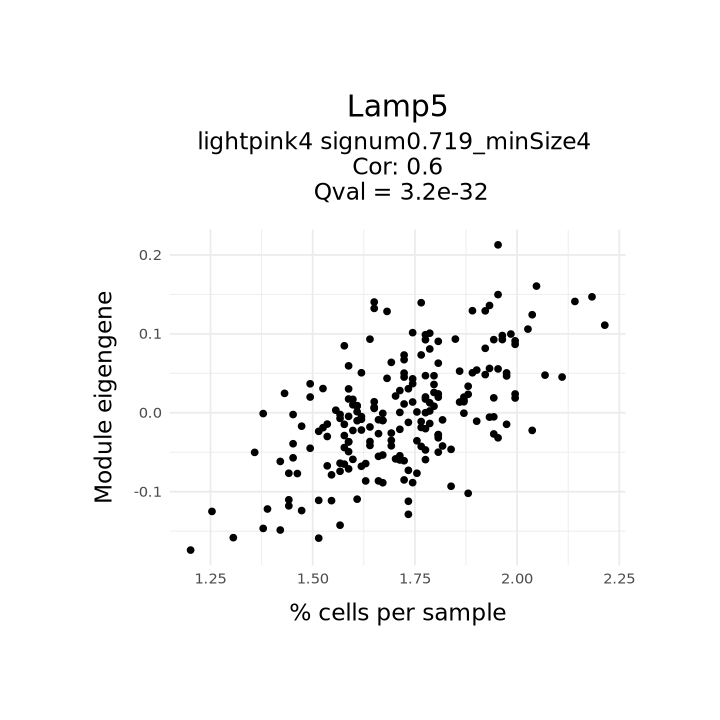

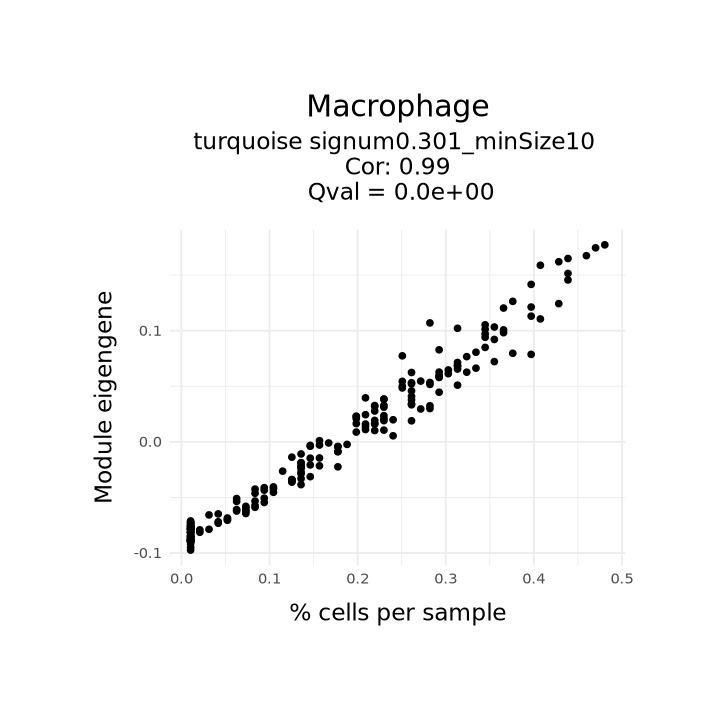

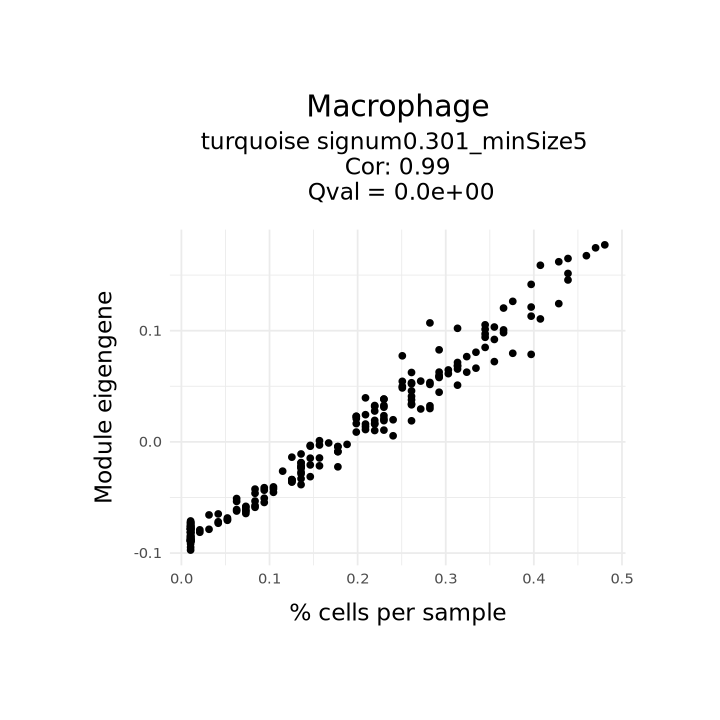

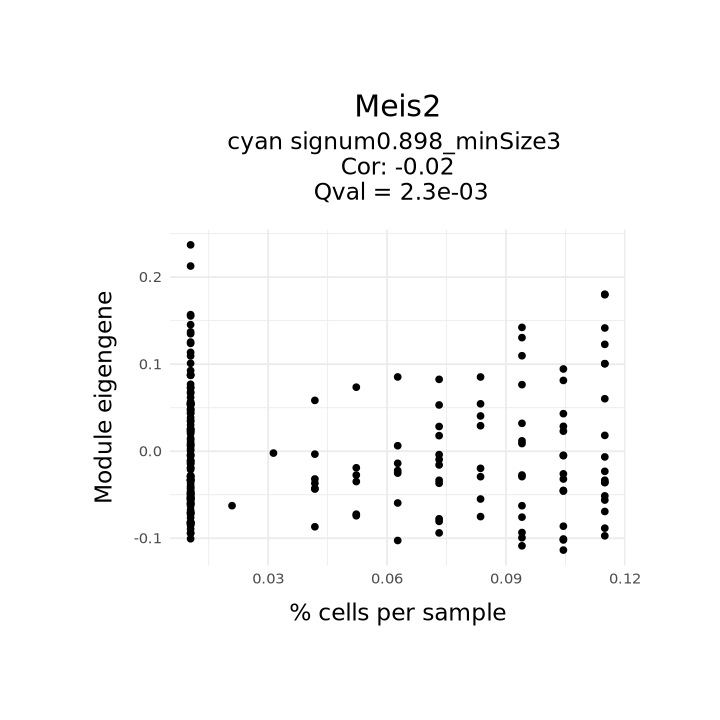

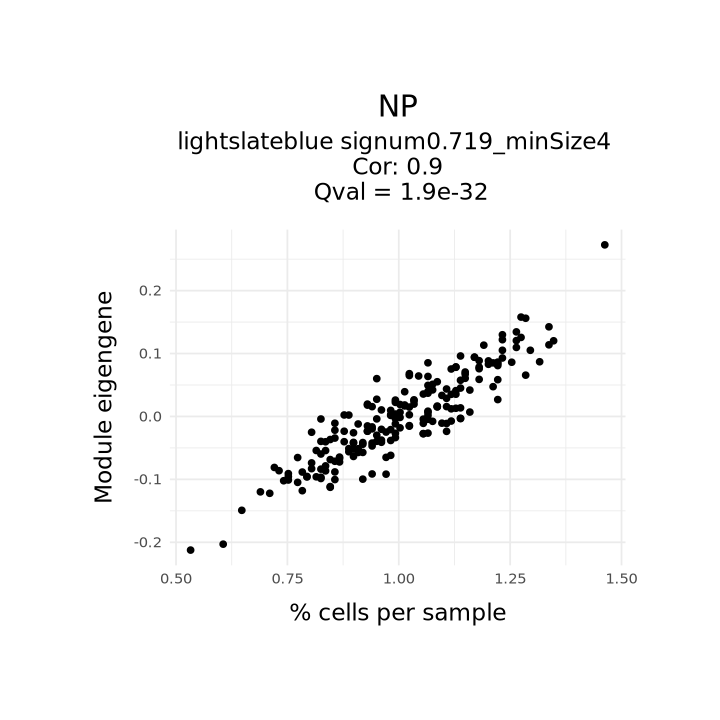

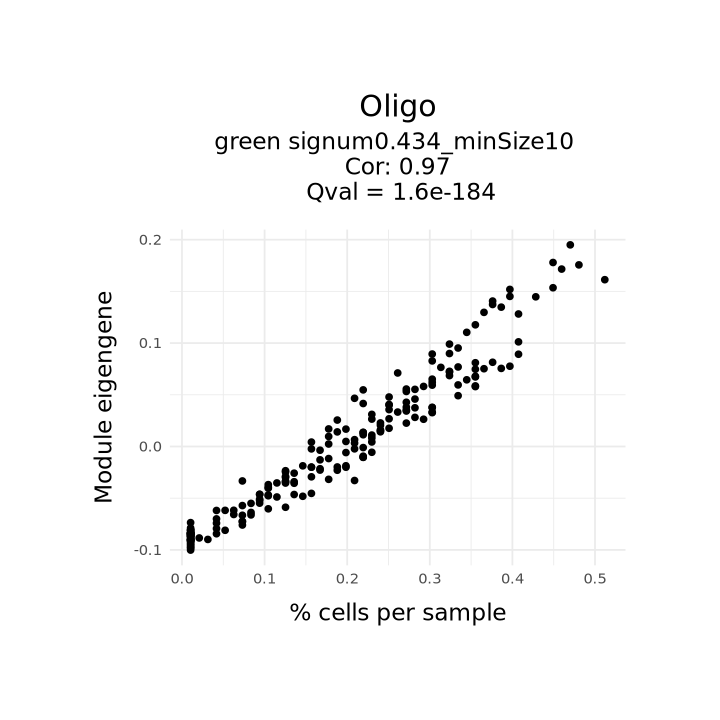

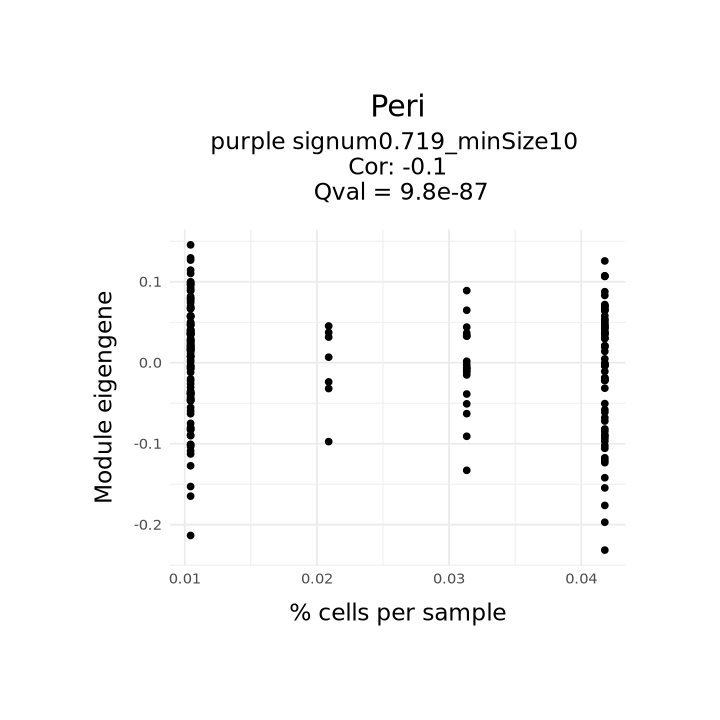

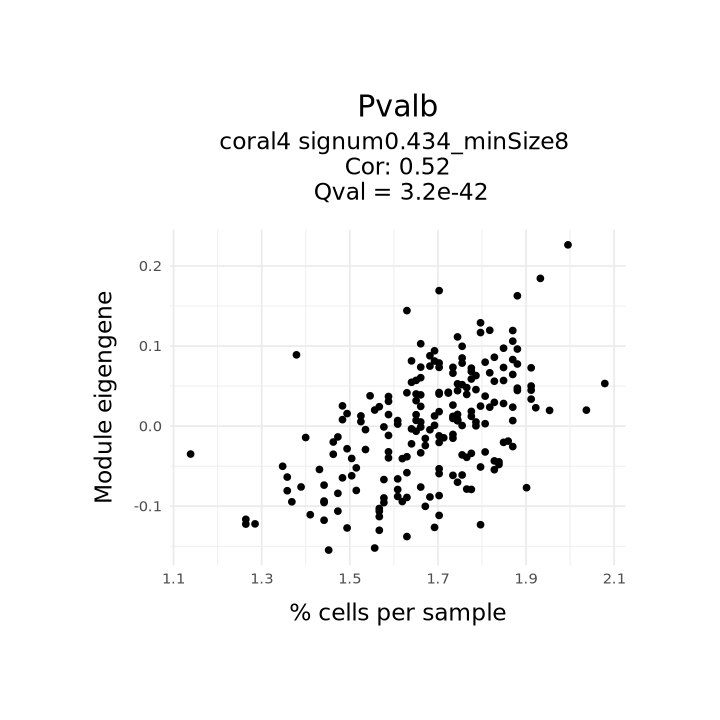

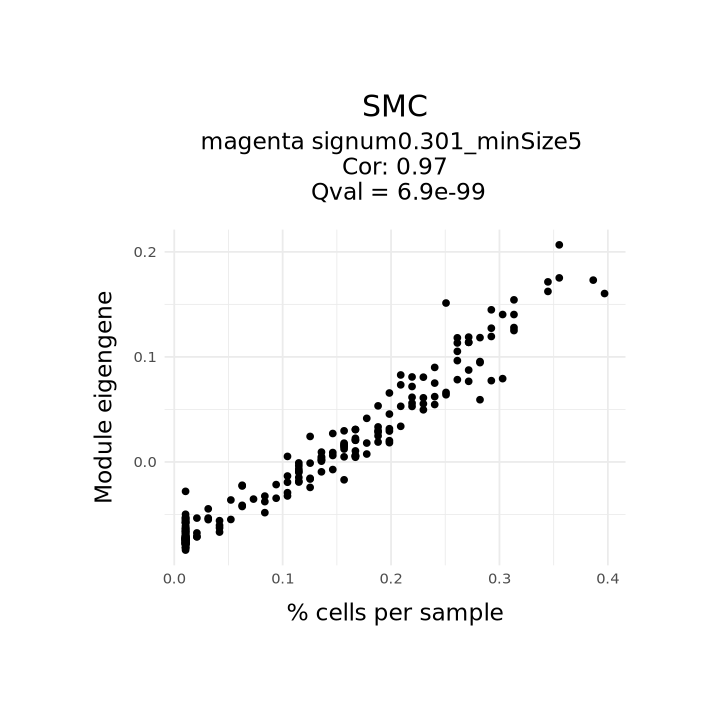

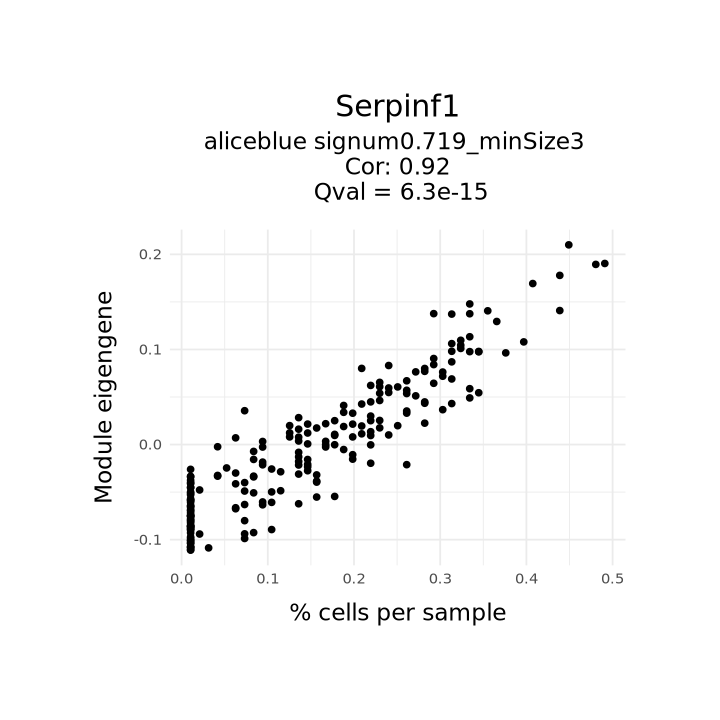

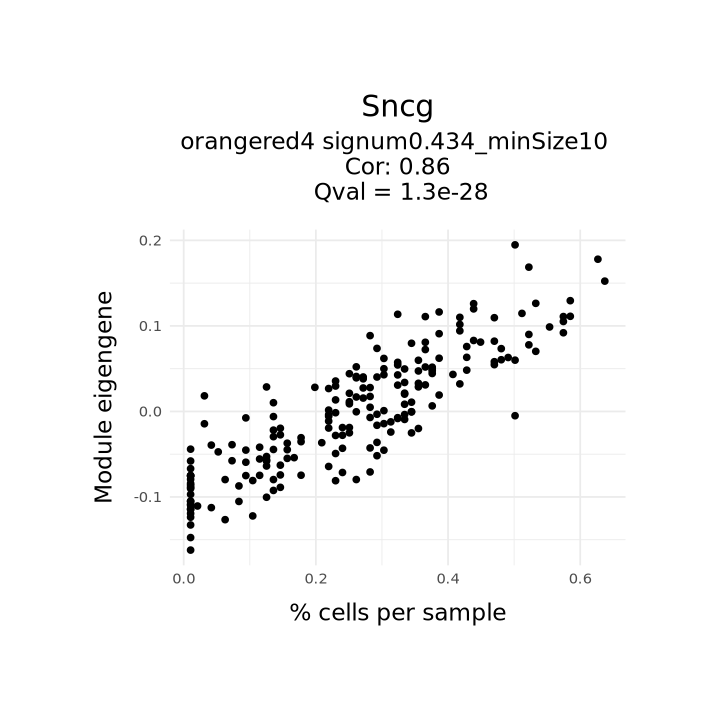

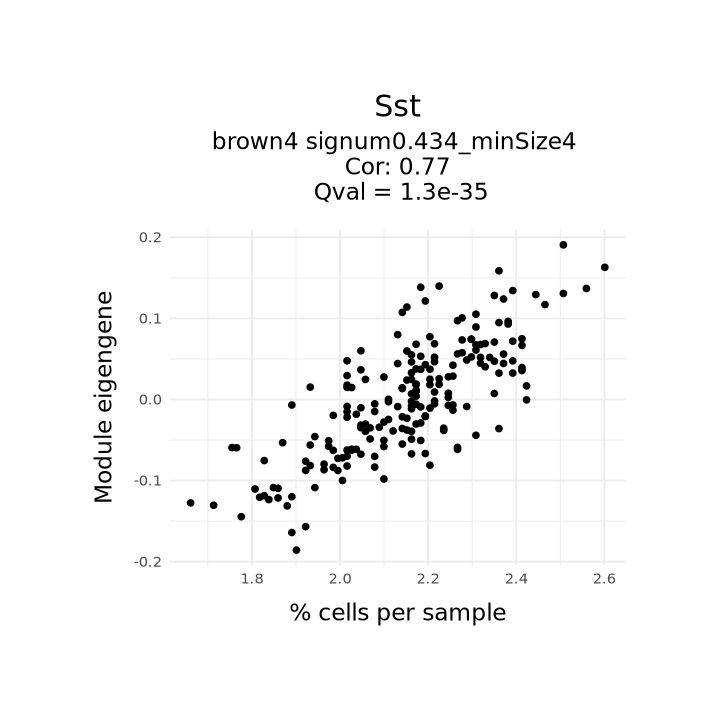

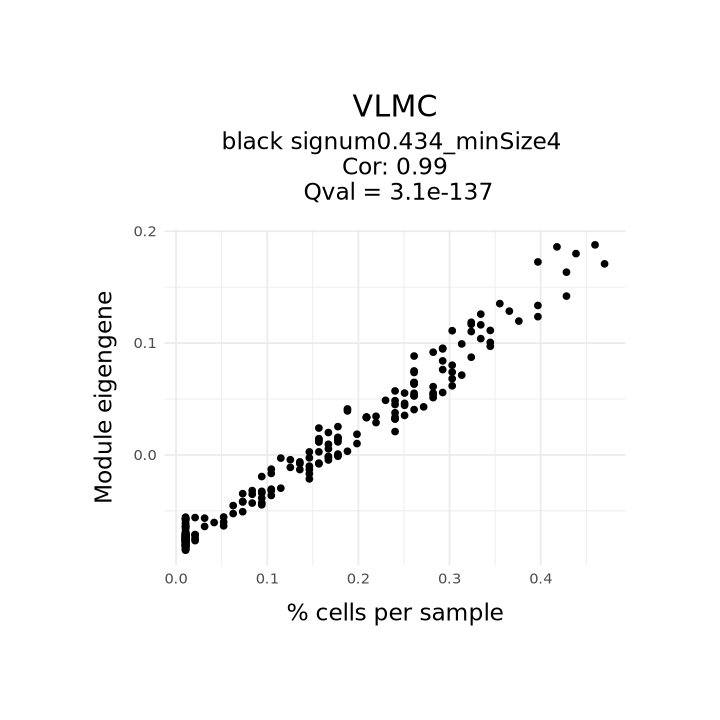

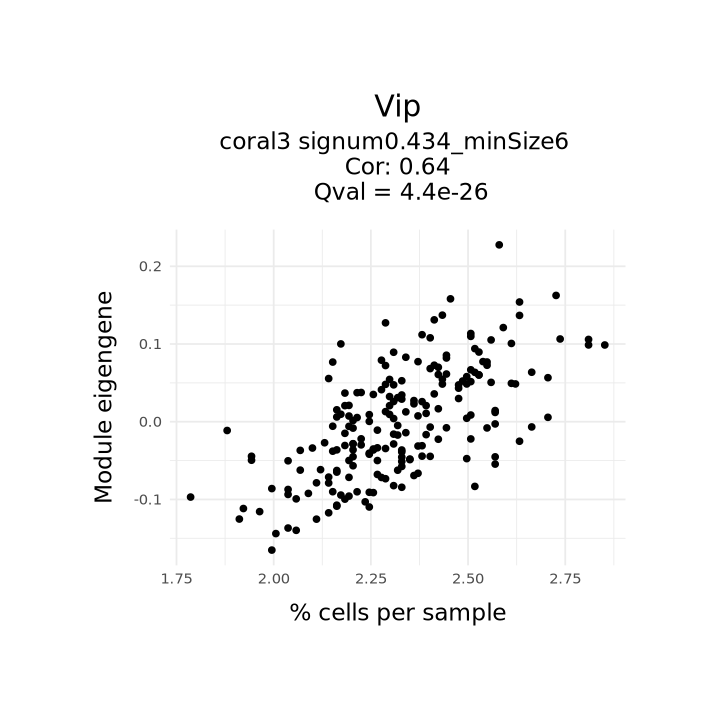

In [128]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Concatonate results

In [79]:
top_corr_mods_0.4pcnt_PosBC_df$Data <- "0.4pcnt_PosBC"
top_corr_mods_25kappa_PosBC_df$Data <- "25kappa_PosBC"
# top_corr_mods_40pcnt_PosBC_df$Data <- "40pcnt_PosBC_fix"
top_corr_mods_50pcnt_PosBC_df$Data <- "50pcnt_PosBC"
top_corr_mods_20SD_PosBC_df$Data <- "20SD_PosBC"

In [80]:
top_corr_mods_0.4pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_0.4pcnt_PosBC_df)
top_corr_mods_25kappa_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_25kappa_PosBC_df)
# top_corr_mods_40pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_40pcnt_PosBC_df)
top_corr_mods_50pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_50pcnt_PosBC_df)
top_corr_mods_20SD_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_20SD_PosBC_df)

In [81]:
cols_idx <- which(colnames(top_corr_mods_0.4pcnt_PosBC_df) %in% c("Cell_type", "Cor", "Old_cor", "Pseudobulk_SD", "PC1V1", "MeanExpr", "Unique_members", "Specificity", "Homogeneity"))

In [82]:
colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1], "_", top_corr_mods_0.4pcnt_PosBC_df$Data[1]
)

colnames(top_corr_mods_25kappa_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_25kappa_PosBC_df)[-1], "_", top_corr_mods_25kappa_PosBC_df$Data[1]
)

# colnames(top_corr_mods_40pcnt_PosBC_df)[-1] <- paste0(
#     colnames(top_corr_mods_40pcnt_PosBC_df)[-1], "_", top_corr_mods_40pcnt_PosBC_df$Data[1]
# )

colnames(top_corr_mods_50pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_50pcnt_PosBC_df)[-1], "_", top_corr_mods_50pcnt_PosBC_df$Data[1]
)

colnames(top_corr_mods_20SD_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_20SD_PosBC_df)[-1], "_", top_corr_mods_20SD_PosBC_df$Data[1]
)

### Compare PosBC results

In [83]:
top_corr_mods_BC_df <- merge(
    top_corr_mods_0.4pcnt_PosBC_df[,cols_idx],
    top_corr_mods_25kappa_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

# top_corr_mods_BC_df <- merge(
#     top_corr_mods_BC_df,
#     top_corr_mods_40pcnt_PosBC_df[,cols_idx],
#     by="Cell_type", all=TRUE, sort=FALSE
# )

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_50pcnt_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_20SD_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- top_corr_mods_BC_df[,order(colnames(top_corr_mods_BC_df))]

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    data.frame(sort(table(cell_meta$cell_subclass))), 
    by.x="Cell_type", by.y="Var1", all=TRUE
)


ERROR: Error in `[.data.frame`(top_corr_mods_20SD_PosBC_df, , cols_idx): undefined columns selected


In [86]:
cols_idx

[1]  1 19 20 21 23

In [85]:
top_corr_mods_20SD_PosBC_df[,cols_idx]

ERROR: Error in `[.data.frame`(top_corr_mods_20SD_PosBC_df, , cols_idx): undefined columns selected


In [59]:
# top_corr_mods_0.4pcnt_PosBC_df[top_corr_mods_0.4pcnt_PosBC_df$Cell_type == "Sncg",]
# kME_df <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/kME_table_06-18-43.csv")
# top_genes <- kME_df[kME_df$`TopModPosBC_8.11e-09` == "darkorchid2", c("Gene", "kMEdarkorchid2")] %>% arrange(-kMEdarkorchid2)
# top_genes
# write.csv(top_genes, file="top_genes.csv", row.names=FALSE)

In [60]:
top_corr_mods_BC_df %>%
  relocate(Freq, .after=Cell_type) %>%
  arrange(Freq)

Cell_type,Freq,Cor_0.4pcnt_PosBC,Cor_15kappa_PosBC,Cor_25kappa_PosBC,Cor_50pcnt_PosBC,Homogeneity_0.4pcnt_PosBC,Homogeneity_15kappa_PosBC,Homogeneity_25kappa_PosBC,Homogeneity_50pcnt_PosBC,MeanExpr_0.4pcnt_PosBC,MeanExpr_15kappa_PosBC,MeanExpr_25kappa_PosBC,MeanExpr_50pcnt_PosBC,Old_cor_0.4pcnt_PosBC,Old_cor_15kappa_PosBC,Old_cor_25kappa_PosBC,Old_cor_50pcnt_PosBC,Pseudobulk_SD_0.4pcnt_PosBC,Pseudobulk_SD_15kappa_PosBC,Pseudobulk_SD_25kappa_PosBC,Pseudobulk_SD_50pcnt_PosBC,Specificity_0.4pcnt_PosBC,Specificity_15kappa_PosBC,Specificity_25kappa_PosBC,Specificity_50pcnt_PosBC,Unique_members_0.4pcnt_PosBC,Unique_members_15kappa_PosBC,Unique_members_25kappa_PosBC,Unique_members_50pcnt_PosBC
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
L4,3,NA,0.1504011,NA,0.2015220,NA,0.9927239,NA,0.8518490,NA,0.02272678,NA,0.01048402,NA,-0.02461285,NA,0.07698462,NA,0.38,NA,0.70,NA,47.8902954,NA,15.384615,NA,1135,NA,16
Peri,4,NA,0.2522680,0.1932410,0.1873673,NA,0.9852596,0.9496533,0.8790533,NA,0.08992893,0.44847966,0.18663322,NA,-0.07314448,0.05267446,-0.16100388,NA,0.51,0.65,0.73,NA,31.3086199,1.272265,8.854167,NA,701,35,17
CR,11,0.2291747,0.2070011,0.2303541,0.1490367,0.8710563,0.8904172,0.9159445,0.8927302,1.64015820,0.35906558,0.57507761,0.24836634,0.129101599,0.19327209,-0.06763805,-0.04376170,0.50,1.57,1.96,0.79,15.2284264,0.9268795,3.276898,10.283688,60,27,60,29
Meis2,11,0.2845981,0.2302433,0.3125991,0.1785107,0.7874547,0.9949139,0.8567619,0.8068180,0.01416564,0.04396504,0.35663564,0.96078083,0.149229893,0.08630561,-0.05137787,-0.08011696,0.50,2.02,2.71,0.74,100.0000000,11.9687771,2.027679,1.056710,7,138,63,30
SMC,55,0.9590460,0.7395172,0.8800080,0.8828202,0.9391225,0.9208406,0.9295218,0.9908321,0.28830932,0.11532388,0.12901273,0.78549982,0.958120433,0.73951723,0.88000800,0.87072285,2.93,13.40,11.55,4.11,53.4188034,22.2368421,24.531377,72.924188,125,507,301,202
VLMC,72,0.9211118,0.8225798,0.9117353,0.8453615,0.9229145,0.9507406,0.9852843,0.9242816,0.19250877,0.12239295,0.26176473,0.18344373,0.921111791,0.63806227,0.90136592,0.83210083,3.63,13.34,16.84,5.17,79.2114695,20.8333333,26.007523,70.877193,221,195,484,202
Serpinf1,78,0.7316211,0.3208066,0.4026167,0.1938398,0.6688854,0.9322153,0.9733656,0.8321743,0.49548560,0.28545641,0.29056466,0.93084122,0.276181507,0.30009104,0.30979272,0.07748015,4.20,16.00,16.64,5.23,31.7073171,1.3323464,3.448276,0.656304,13,36,66,19
Macrophage,85,0.9739987,0.9103410,0.9965619,0.8790042,0.9833021,0.9787520,0.9982113,0.9938854,0.32976571,0.01655297,0.32746280,0.68189793,0.952347615,0.88073115,0.97445447,0.87358583,4.47,18.47,17.12,5.79,95.4687500,38.4100045,87.630058,93.563579,611,860,1516,596
Macrophage,85,0.9739987,0.9103410,0.9965619,0.8790042,0.9833021,0.9787520,0.9982113,0.9938854,0.32976571,0.01655297,0.32746280,0.68189793,0.952347615,0.88073115,0.97445447,0.87409913,4.47,18.47,17.12,5.79,95.4687500,38.4100045,87.630058,93.563579,611,860,1516,596


### Some cell types that are not being well identified in **any** dataset:

No modules exist:
- Meis2 (11 cells)
- CR (11 cells)
- Peri (4 cells)
- L4 (3 cells)

Modules exist, but not being identified
- Serpinf1 (78 cells)
- Sncg (148 cells)

Modules exist, "decent" but not great modules being identifeid 
- L2_3_IT (325 cells)

# Misc

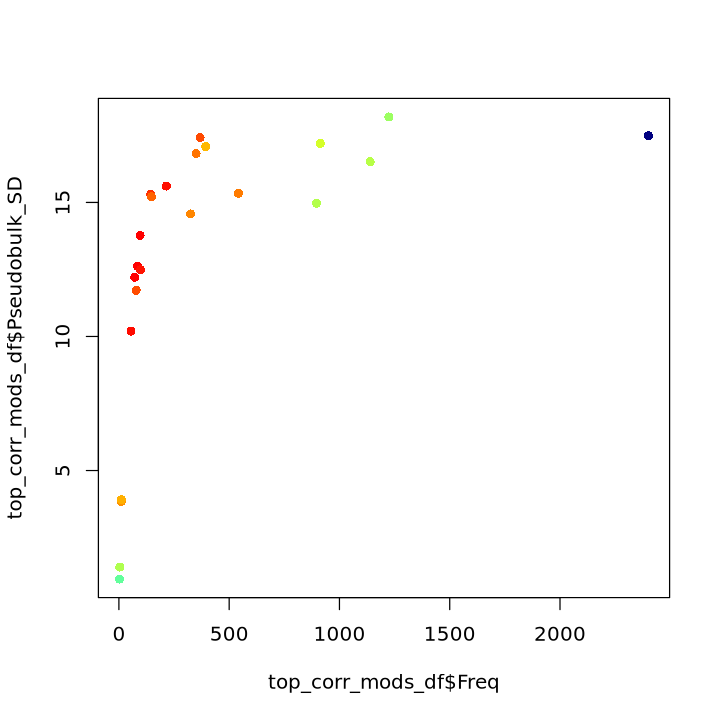

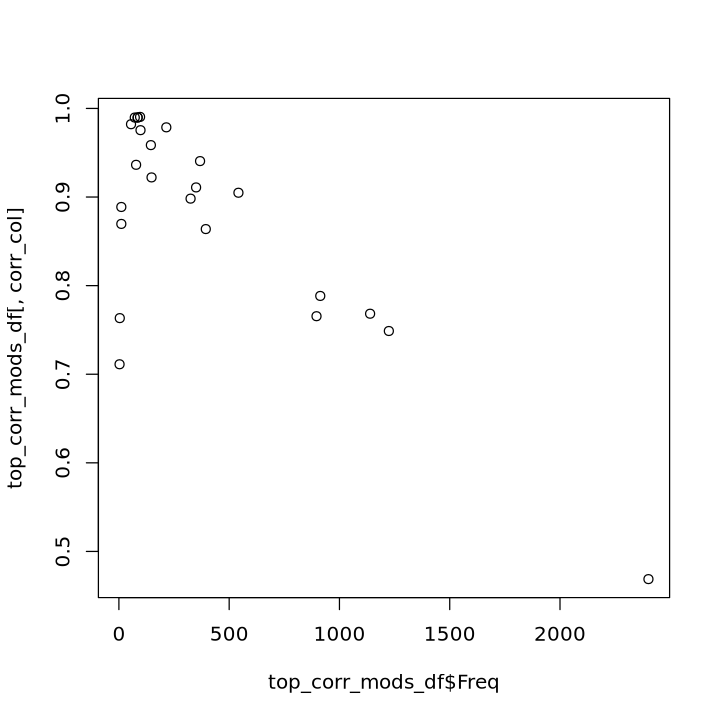

In [78]:
plot_corr_vs_stats(cell_meta, top_corr_mods_20SD_PosBC_df)

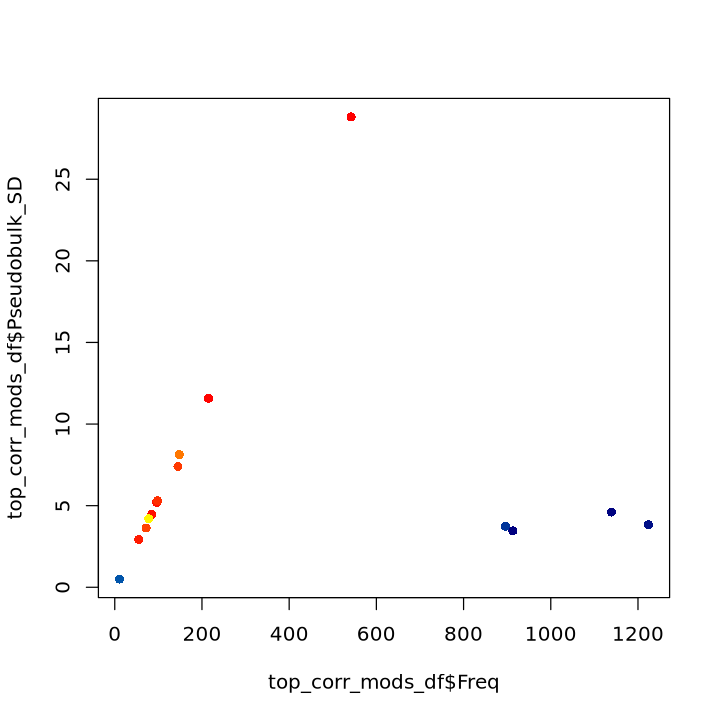

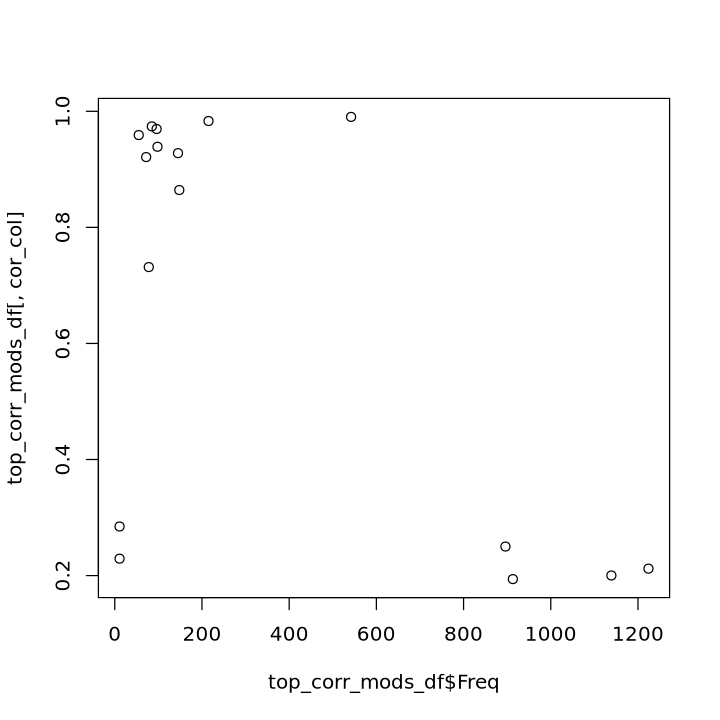

In [ ]:
plot_corr_vs_stats(cell_meta, top_corr_mods_0.4pcnt_PosBC_df)

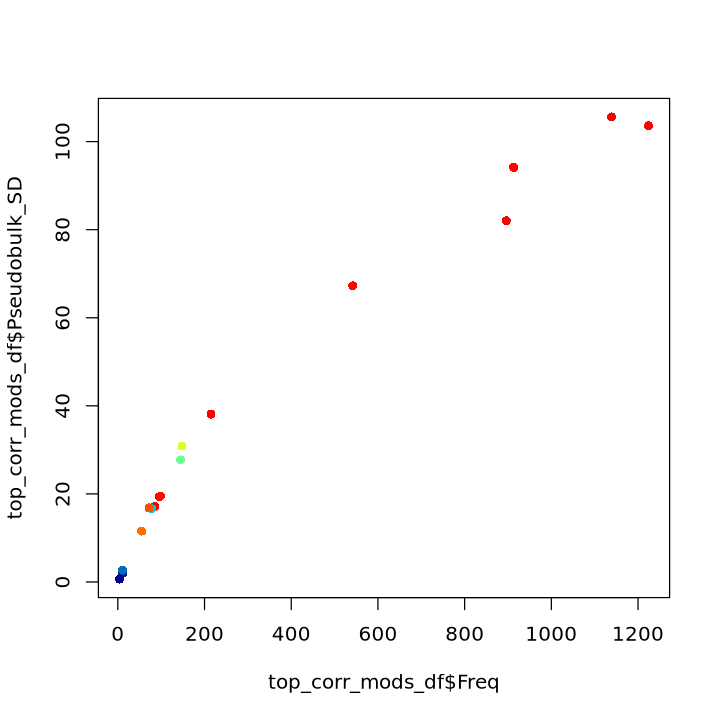

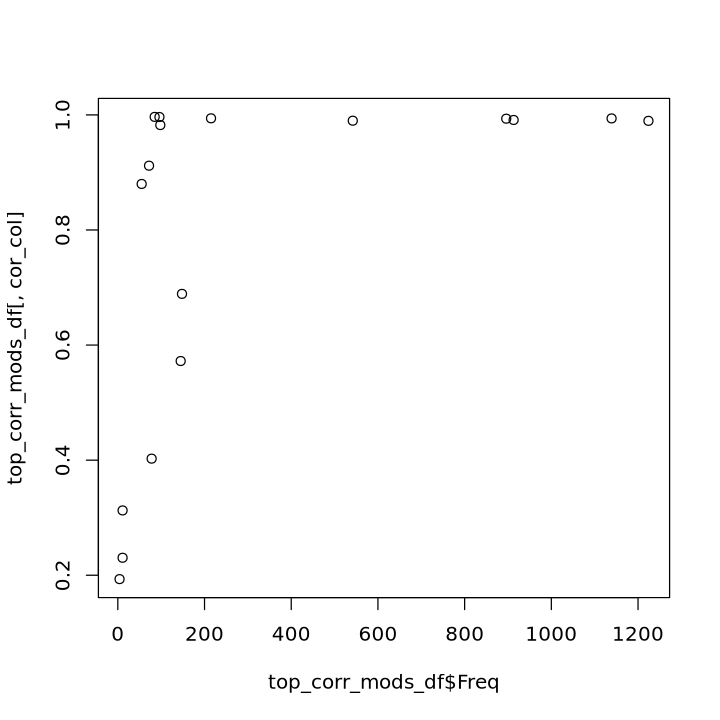

In [ ]:
plot_corr_vs_stats(cell_meta, top_corr_mods_25kappa_PosBC_df)

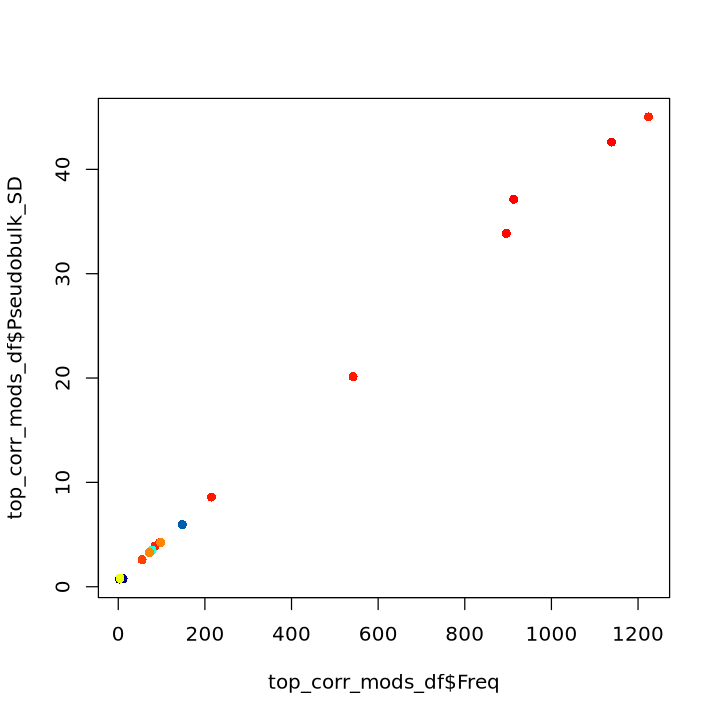

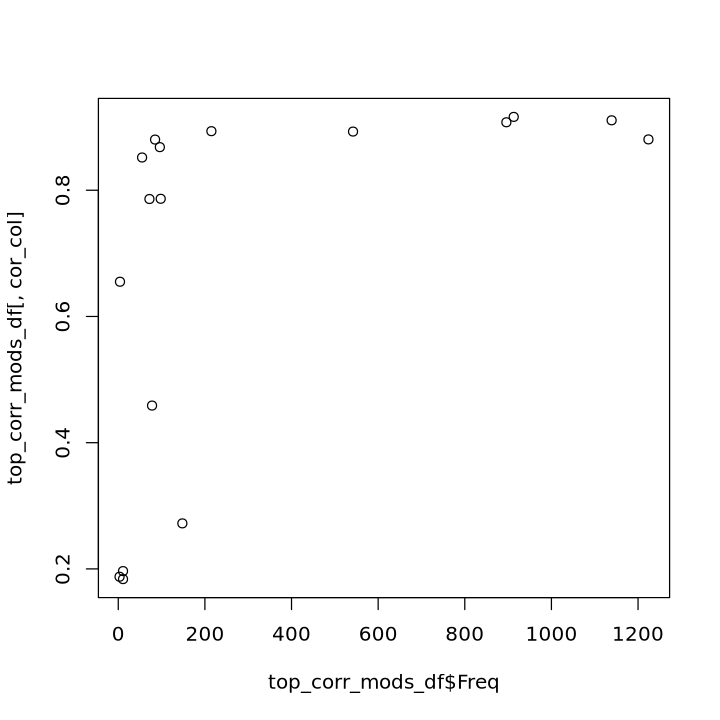

In [ ]:
plot_corr_vs_stats(cell_meta, top_corr_mods_40pcnt_PosBC_df)